<a href="https://www.kaggle.com/code/santiagotesta/tp3-g14?scriptVersionId=102308719" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn as sk
import multiprocessing
from sklearn import tree
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from tensorflow import keras
from warnings import simplefilter
from pandas.core.common import SettingWithCopyWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=UserWarning)
simplefilter("ignore", category=SettingWithCopyWarning)
sns.set(rc = {'figure.figsize':(8,8)})
N_CPU= multiprocessing.cpu_count()
tf.config.threading.set_inter_op_parallelism_threads(N_CPU*2)

# Carga de Datos:

## American Express - Default Prediction 

* [Link a la competencia](https://www.kaggle.com/competitions/amex-default-prediction)

El objetivo de este trabajo es predecir la probabilidad de que un cliente no pague el monto del saldo de su tarjeta de crédito (target = 1) en el futuro en función de su perfil de cliente mensual. La variable binaria target se calcula observando la ventana de rendimiento de 18 meses después del último extracto de la tarjeta de crédito, y si el cliente no paga el monto adeudado en 120 días después de la fecha del último extracto, se considera un evento de incumplimiento.

## Sampleo del Dataset:

Como este conjunto de datos de entrenamiento es muy grande (Posee un peso de alrededor de 16~17 GB), realizamos un sampleo para trabajar con un subconjunto del mismo tomando solo un 5% del total de los datos (Dejandonos con aproximadamente 900 Mb).

Para realizar este sampleo, utilizaremos la funcón **sample_without_replacement()** y estableceremos su **random_state** a una seed, la cual se genera a partir del numero de nuestro grupo utilizando la siguiente formula:

> (31416 × (número-grupo)) % 1000

## Repositorio con el sampleo:

Ya que la memoria de la maquina de Kaggle no fue suficiente para levantar el set entero, realizamos el sampleo de forma local y generamos un nuevo dataset en Kaggle con el mismo.

* [Repositorio con el codigo del sampleo.](https://github.com/stesta1/AMEX-DefaultPrediction/tree/sampleo)
* [Enlace del nuevo dataset sampleado en Kaggle.](https://www.kaggle.com/datasets/santiagotesta/train-data-sampled-g14)

### Seed Grupo:

* Incluimos la seed del grupo a la notebook para utilizarla al balancear el dataset y generar redes neuronales mas adelante...

In [2]:
NUM_GRUPO = 14
SEED_GRUPO = (31416 * NUM_GRUPO) % 1000

# Visualización de los datos:

In [3]:
df_train_data = pd.read_csv("/kaggle/input/train-data-sampled-g14/train_sampled_G14.csv")
df_train_labels = pd.read_csv("../input/amex-default-prediction/train_labels.csv")

In [4]:
df_train_data

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,3e52dec043ba1830f11dec8504f8dad5f4c88e31db5df4...,2018-01-08,0.858942,0.000937,0.003104,0.816093,0.005505,NaN,0.009372,0.005367,...,NaN,NaN,1.004304,0.008963,0.862856,0.058511,1.003286,0.003099,0.279170,0
1,e3987751af785c63681334119e0ae8ef61b9195c535fa1...,2018-03-23,0.636110,0.118810,0.013186,0.811999,0.005139,0.182632,0.009313,0.001701,...,NaN,NaN,0.001163,0.000047,0.001250,NaN,0.005394,0.005578,0.009653,0
2,ca5cc31bdd33599e7f3e4f0af37bf53c90f441ff9d426e...,2017-09-07,0.649134,0.592575,0.052248,0.059354,0.004992,0.179298,0.007444,0.142352,...,NaN,NaN,0.007144,0.005600,0.009201,NaN,0.009573,0.007255,0.006836,0
3,708495d85d01123238b8feea562f321df6306e9d131994...,2017-03-05,0.587330,0.004235,0.621175,0.037618,0.008271,0.160576,0.007185,0.461215,...,NaN,NaN,0.001627,0.002387,0.007506,NaN,0.004292,0.000031,0.009824,0
4,8e6325448ec00c432151b1f678db276baa1cf31885faa6...,2017-03-28,0.677123,0.564526,0.119460,1.004468,0.009573,0.118454,0.007558,0.006660,...,NaN,NaN,0.003359,0.000864,0.003049,NaN,0.000476,0.005799,0.008635,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276568,b6259aafe1cbc4057902bfebf7be7fe82110ad1d65c96e...,2018-03-07,0.588909,0.001066,0.043523,1.004289,0.007397,0.314670,0.008588,0.002235,...,NaN,NaN,0.008907,0.003037,0.009398,NaN,0.006577,0.001516,0.006332,0
276569,8a14e8811699dd4915d710ffbc3c0e81da1b6f36994a63...,2017-06-27,1.007882,0.007331,0.016122,1.003101,0.009691,0.134467,0.008111,0.005704,...,NaN,NaN,0.005209,0.008816,0.001328,NaN,0.006936,0.009363,0.001241,0
276570,d88b441c8d31ae094880074ad914714fe3dd9836acccbe...,2018-03-23,0.719087,0.007391,0.005794,0.817552,0.006848,0.129134,0.009438,0.010734,...,NaN,NaN,0.002578,0.002462,0.002067,NaN,0.001170,0.001336,0.007757,0
276571,a31070910c61e92852b56ba61538750021491de5782396...,2017-09-18,0.691608,0.004745,0.385502,0.034945,0.002566,0.418757,0.001406,0.305104,...,NaN,NaN,0.001581,0.009791,0.001876,NaN,0.000892,0.000459,0.004343,1


Analizamos la distribución de la variable target dentro del dataset. Como se puede apreciar en el siguiente gráfico, **el conjunto se encuentra desbalanceado** (es lógico que la cantidad de clientes que paga el saldo de su cuenta sea mayor). 

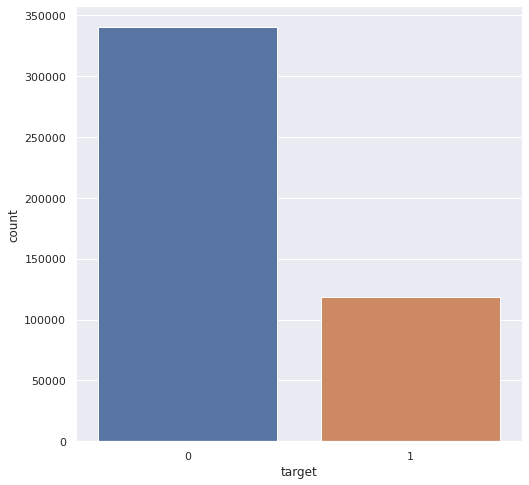

In [5]:
g = sns.countplot(x = "target", data = df_train_labels)

Acto seguido, visualizamos la distribución de los valores en los atributos categóricos del dataset. Para estas variables categoricas, se presentarán gráficos del tipo countplot, los cuales cuentan, para cada variable, la cantidad de repeticiones de cada valor posible que estas pueden tomar.

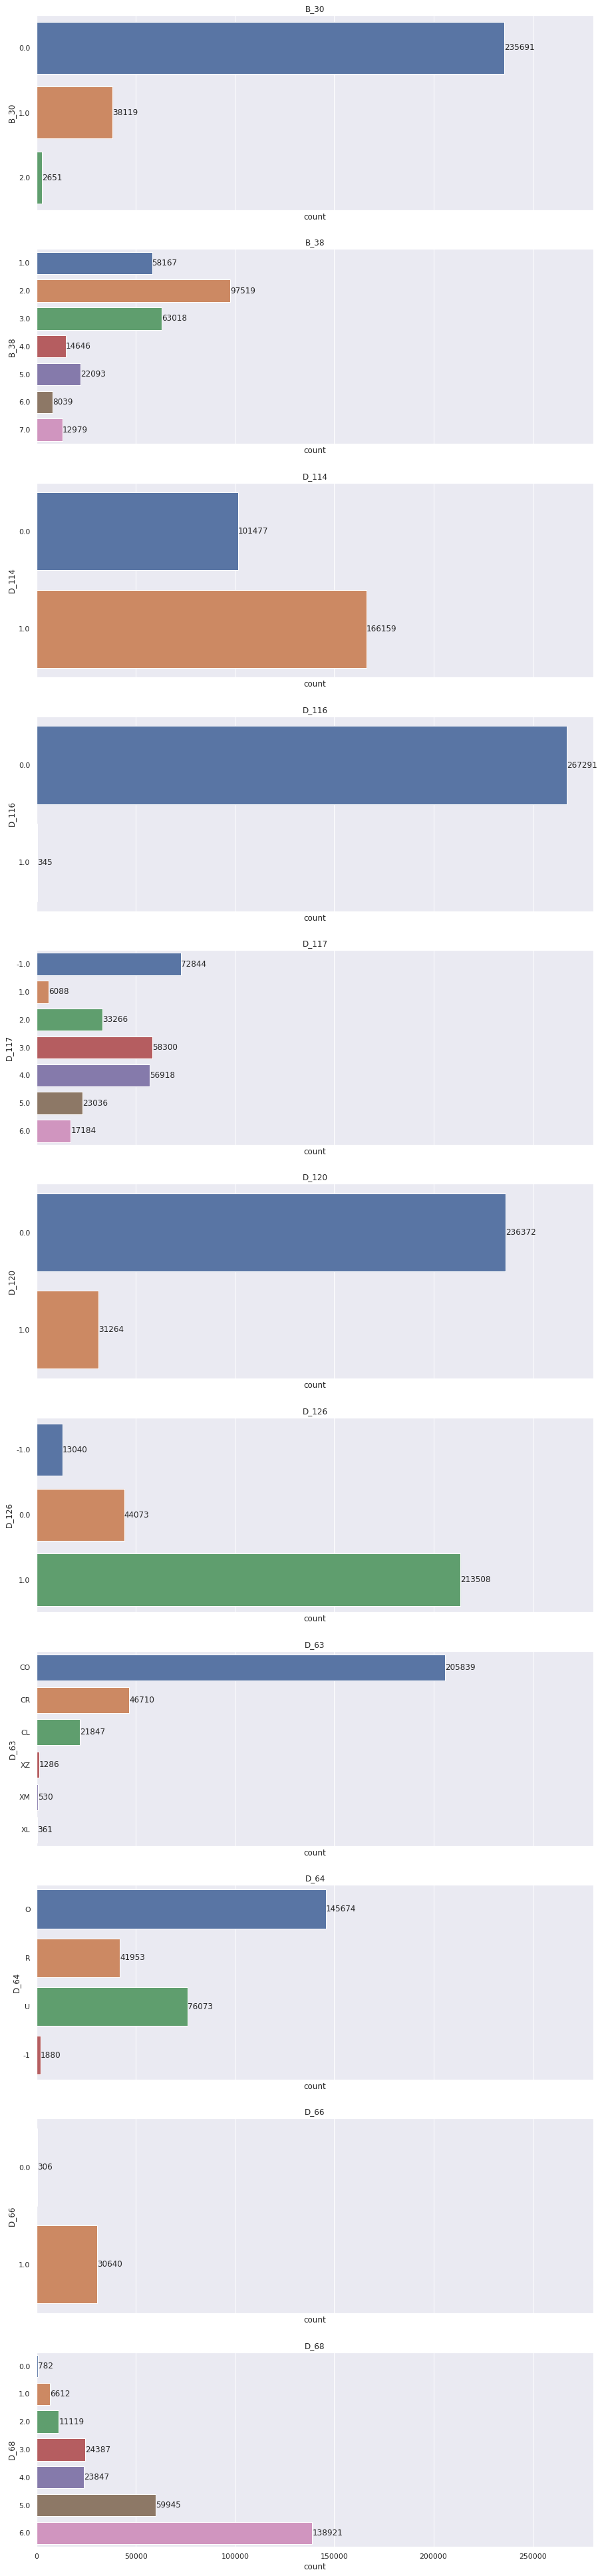

In [6]:
categoricas = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
fig, ax = plt.subplots(11, 1, figsize=(15, 70), sharex=True)

for i, col in enumerate(categoricas):
    graph = sns.countplot(y=df_train_data[col], ax=ax[i])
    ax[i].set_title(*[col])
    graph.bar_label(graph.containers[0])

A partir de los gráficos expuestos, se puede observar que hay algunas variables que no están bien distribuidas en sus valores posibles, es decir, la mayoría del conteo recae sobre unos pocos valores de estas variables. Estas mismas son las variables B_30, D_116, D_120, D_126, D_63 y D_66, mientras que el resto de ellas se encuentran balanceadas.

In [7]:
sns.set(rc = {'figure.figsize':(8,8)})

# Ing. Caracteristicas:

## Balanceo del set:

Distribucion de Target en el dataset original:

<AxesSubplot:xlabel='target', ylabel='count'>

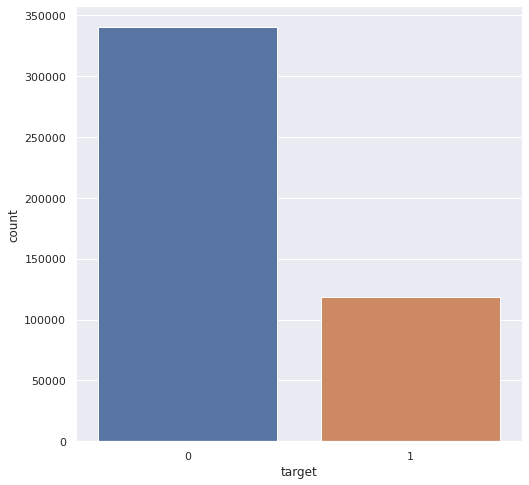

In [8]:
sns.countplot(x = "target", data = df_train_labels)

<AxesSubplot:xlabel='target', ylabel='count'>

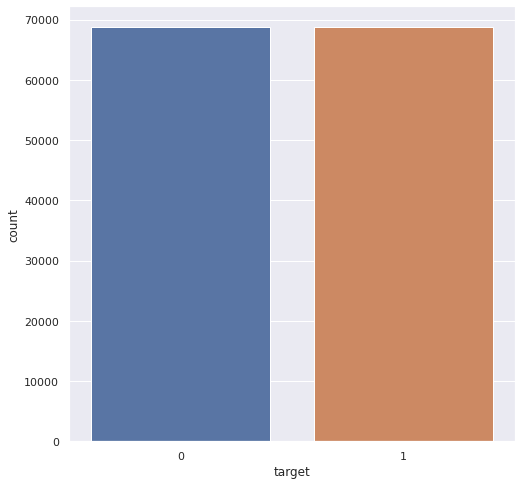

In [9]:
min_n = df_train_data['target'].value_counts().min()
df_train_data = df_train_data.groupby('target', as_index=False, group_keys=False).apply(lambda x: x.sample(n=min_n, random_state = SEED_GRUPO))
sns.countplot(x = "target", data = df_train_data)

* Realizamos un undersampling de la clase Target = 0 para igualar los Target = 1, utilizando como random_state la SEED_GRUPO.

## Reduccion de Dimensionalidad - Columnas:

El dataset original posee 193 columnas, muchas de las cuales no tienen una gran correlación con la variable target, como se acaba de analizar. Por lo tanto, decidimos no tener en consideración aquellas columnas que no cumplan con un mínimo umbral de correlación (en módulo) con la variable target. 

In [10]:
correlaciones_columnas = (df_train_data.corrwith(df_train_data["target"]).abs().sort_values(ascending=True)).drop('target')
correlaciones_columnas.describe()

count    185.000000
mean       0.175911
std        0.144980
min        0.000121
25%        0.067410
50%        0.132271
75%        0.235168
max        0.666256
dtype: float64

A partir de la tabla anteriormente expuesta, se puede observar que el tercer cuartil de la correlación entre las columnas y target tiene un valor de 0.235168. Al usar este valor como umbral, estaríamos usando un cuarto de la cantidad de columnas que se tenían originalmente, siendo estas las que mayor correlación tienen con el target. Por lo tanto, establecemos este valor como piso.

In [11]:
df_filtrado = df_train_data.copy()
correlaciones_columnas.dropna()
correlaciones_columnas_dict = correlaciones_columnas.to_dict()
correlaciones_columnas_dict.pop('D_87', None)
correlaciones_columnas_dict
umbral = 0.235168
columns_to_drop = ['D_87'] # Se elimina D_87 por ser NaN
for col, corr in correlaciones_columnas_dict.items():
    if corr < umbral:
        columns_to_drop.append(col)
df_filtrado.drop(columns_to_drop, axis=1, inplace=True)
df_filtrado

,customer_ID,S_2,P_2,B_1,B_2,R_1,S_3,B_3,D_42,D_43,...,D_77,B_28,B_30,B_33,B_37,R_27,B_38,D_127,D_131,target
247462,c9bd3b8e9a061b81c3f94b92c80977c5b4154d3695dba3...,2017-09-07,0.650563,0.334561,0.032087,0.000278,0.159321,0.270453,NaN,0.276738,...,0.186035,0.092162,1.0,0.000852,0.335233,1.009736,5.0,0.004082,0.004622,0
61392,41833fe733f9ecc720258fe656ffae17ef2c432169e5b4...,2018-01-26,0.845354,0.014661,1.003005,0.006111,0.059987,0.005424,NaN,NaN,...,0.776614,0.118719,0.0,1.008084,0.013787,1.002788,2.0,1.003084,0.007921,0
155273,55c5f56f347dbe7895e38d2a52a8643ddd632b7a32001a...,2017-06-24,0.860423,0.007062,0.818051,0.007428,0.174510,0.000335,NaN,0.009585,...,0.251304,0.013723,0.0,1.005307,0.005180,1.009801,1.0,0.002157,0.005188,0
176354,b142e155a5d78171cf103b35eae62e2c1714bc282de639...,2017-09-30,0.828892,0.012427,1.008093,0.018129,0.166912,0.010756,NaN,0.019320,...,NaN,0.058108,0.0,1.003585,0.015826,1.007780,2.0,0.009497,0.005852,0
91294,9b1b2dfe5fce6e0237297154f13b7c4f97160666afd614...,2018-01-07,0.848435,0.012845,1.001285,0.004187,0.095897,0.004087,NaN,0.037725,...,0.029500,0.064407,0.0,1.007804,0.019741,1.008842,3.0,1.008596,1.013176,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39235,b66b76de877ced2755cb0ff30507c3f64c10cecee52730...,2017-08-17,0.251325,0.061579,1.009665,0.002755,0.133108,0.008876,NaN,1.096011,...,NaN,0.197477,0.0,1.006780,0.059651,0.012207,3.0,0.008886,0.007369,1
53542,6510eca17b2ef08566e952db9dcf922ba57d6572d65f9c...,2018-01-03,0.410099,0.109138,0.080330,0.502055,0.586159,0.140071,NaN,0.063398,...,NaN,0.167969,0.0,0.005615,0.114095,1.000029,1.0,0.003410,0.002807,1
199141,1e775a757204cf13600f1c56432a94bb88e3c1600d316d...,2017-09-23,0.420529,0.054901,0.073554,0.254055,0.209672,0.110149,0.167534,0.620982,...,NaN,0.016129,0.0,0.003380,0.048994,0.008498,1.0,0.000806,0.008663,1
2317,5db0439665481ea9ce288f4d363e70076924079850a52e...,2017-06-26,0.467831,0.127507,0.589934,0.003379,0.098933,0.089988,NaN,NaN,...,NaN,0.739799,0.0,0.004201,0.124892,1.002139,3.0,0.000084,0.004239,1


Antes de pasar a la reduccion de dimensionalidad para las filas, tenemos que realizar unas transformaciones en el set para las variables categoricas **D_63** y **D_64**

## Generacion de nuevas columnas / Modificacion de columnas:

Puesto que las variables 'D_63' y 'D_64' son categoricas y de tipo String, se utiliza la función get_dummies para reemplazarlos y así poder calcular el promedio de sus apariciones y no estas información. Estas dos variables, a partir de lo expuesto anteriormente, se encuentran altamente correlacionados con el target, por lo que, si se descartaran, se perdería mucha información.

In [12]:
dummies1 = pd.get_dummies(df_filtrado.D_64)
dummies2 = pd.get_dummies(df_filtrado.D_63)
df_filtrado = pd.concat([df_filtrado, dummies1, dummies2], axis='columns')
df_filtrado.drop(['D_63', 'D_64'], axis='columns', inplace = True)

In [13]:
df_filtrado

,customer_ID,S_2,P_2,B_1,B_2,R_1,S_3,B_3,D_42,D_43,...,-1,O,R,U,CL,CO,CR,XL,XM,XZ
247462,c9bd3b8e9a061b81c3f94b92c80977c5b4154d3695dba3...,2017-09-07,0.650563,0.334561,0.032087,0.000278,0.159321,0.270453,NaN,0.276738,...,0,0,0,1,0,1,0,0,0,0
61392,41833fe733f9ecc720258fe656ffae17ef2c432169e5b4...,2018-01-26,0.845354,0.014661,1.003005,0.006111,0.059987,0.005424,NaN,NaN,...,0,1,0,0,1,0,0,0,0,0
155273,55c5f56f347dbe7895e38d2a52a8643ddd632b7a32001a...,2017-06-24,0.860423,0.007062,0.818051,0.007428,0.174510,0.000335,NaN,0.009585,...,0,0,0,1,0,1,0,0,0,0
176354,b142e155a5d78171cf103b35eae62e2c1714bc282de639...,2017-09-30,0.828892,0.012427,1.008093,0.018129,0.166912,0.010756,NaN,0.019320,...,0,1,0,0,1,0,0,0,0,0
91294,9b1b2dfe5fce6e0237297154f13b7c4f97160666afd614...,2018-01-07,0.848435,0.012845,1.001285,0.004187,0.095897,0.004087,NaN,0.037725,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39235,b66b76de877ced2755cb0ff30507c3f64c10cecee52730...,2017-08-17,0.251325,0.061579,1.009665,0.002755,0.133108,0.008876,NaN,1.096011,...,0,0,0,1,1,0,0,0,0,0
53542,6510eca17b2ef08566e952db9dcf922ba57d6572d65f9c...,2018-01-03,0.410099,0.109138,0.080330,0.502055,0.586159,0.140071,NaN,0.063398,...,0,1,0,0,0,1,0,0,0,0
199141,1e775a757204cf13600f1c56432a94bb88e3c1600d316d...,2017-09-23,0.420529,0.054901,0.073554,0.254055,0.209672,0.110149,0.167534,0.620982,...,0,1,0,0,0,1,0,0,0,0
2317,5db0439665481ea9ce288f4d363e70076924079850a52e...,2017-06-26,0.467831,0.127507,0.589934,0.003379,0.098933,0.089988,NaN,NaN,...,0,0,1,0,1,0,0,0,0,0


## Reduccion de Dimensionalidad - Filas:

In [14]:
datos = df_filtrado.pivot_table(columns=['customer_ID'], aggfunc='size')
datos.describe()

count    114877.000000
mean          1.196741
std           0.465873
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           5.000000
dtype: float64

El hecho de que existan diferentes entradas para ciertos ID significa que el banco posee un historial de registros de ellos.

Ante esto, podemos optar por distintos caminos: podríamos tomar el registro más reciente o el más antiguo, o bien hacer un promedio entre ambas y desestimar el resto; el que tenga el valor máximo o mínimo entre las variables más o menos correlacionadas con el target; o bien se podrían promediar.

Al tener diversas variables de las cuales solo se conocen de qué tipo son -morosidad, gastos, pago, balance, riesgo- pero no conocer en específico qué es cada una de las columnas, elegir valores basado en una sola de ellas o elegir un solo registro sería un desaprovechamiento de los datos, ya que los demás datos desestimados no se terminan teniendo en cuenta. Por lo tanto, para aprovechar al máximo esta información extra de estos clientes, hemos optado por calcular un promedio de cada variable de todos los registros repetidos, para obtener un único registro con todas las variables balanceadas.

* A partir de la tabla anterior, se observa que el valor máximo de repeticiones es 5.

In [15]:
datos_dict = datos.to_dict()
values_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
for value in datos_dict.values():
    values_dict[value] += 1
values_dict

{1: 95308, 2: 16871, 3: 2387, 4: 288, 5: 23}

[Text(0, 0, '95308'),
 Text(0, 0, '16871'),
 Text(0, 0, '2387'),
 Text(0, 0, '288'),
 Text(0, 0, '23')]

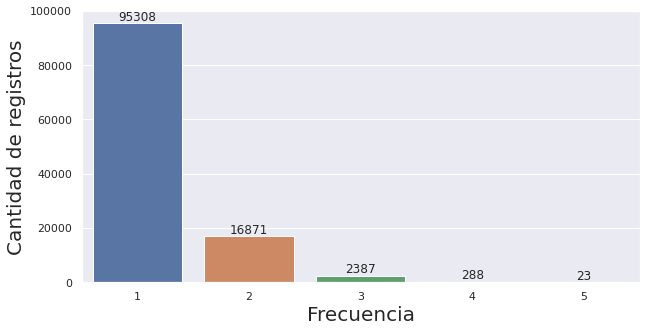

In [16]:
plt.rcParams['figure.figsize'] = (10,5)
freq = sns.countplot(x=datos)
freq.set_xlabel("Frecuencia", fontsize=20)
freq.set_ylabel("Cantidad de registros", fontsize=20)
abs_values = values_dict.values()
freq.bar_label(container=freq.containers[0], labels=abs_values)

Para verificar que la cantidad de registros eliminados haya sido la correcta, iteramos sobre el diccionario values_dict, que nos indica la cantidad de clientes que poseen N registros repetidos. Si un cliente posee N registros, se eliminarán N-1 registros suyos, ya que los N registros originales quedan reemplazados por el registro del promedio entre ellos. Por lo tanto, calculamos la cantidad de filas a eliminar:

In [17]:
cant_eliminadas = 0
for cant_repeticiones, cant_repetidos in values_dict.items():
    cant_eliminadas += cant_repetidos * (cant_repeticiones - 1)
cant_eliminadas

22601

In [18]:
len(df_filtrado) - cant_eliminadas

114877

In [19]:
df_filtrado = df_filtrado.groupby('customer_ID').mean().reset_index()
df_filtrado

,customer_ID,P_2,B_1,B_2,R_1,S_3,B_3,D_42,D_43,D_44,...,-1,O,R,U,CL,CO,CR,XL,XM,XZ
0,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.884522,0.003495,0.818569,0.007541,NaN,0.000859,NaN,NaN,0.004704,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,0.477116,0.009413,1.009217,0.007775,0.267037,0.125927,NaN,0.057729,0.002877,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...,1.005008,0.097292,0.076512,0.002090,0.114884,0.218431,NaN,0.014638,0.003558,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0001812036f1558332e5c0880ecbad70b13a6f28ab04a8...,0.393758,0.715061,0.019414,0.007027,1.618023,0.324966,NaN,0.355073,1.125134,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0003e58375faf90552b2861c1ccea4ee5757827cbb6ecd...,0.829184,0.009911,0.816854,0.001524,0.385820,0.010635,NaN,0.086856,0.003417,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114872,fffec7d7e1ca804c86f1ffdaac389c33f8039ed35bf412...,0.703939,0.008331,0.811022,0.002205,NaN,0.007565,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
114873,fffee847c5c1af7dbdd36d98fea882893256c422cde86c...,0.629187,0.000169,1.005938,0.008702,0.162039,0.005260,0.001686,0.064836,0.252621,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
114874,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,0.863153,0.431408,0.030639,0.004702,0.324895,0.303498,NaN,NaN,0.125581,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
114875,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,0.793250,0.024697,0.182818,0.000660,0.200836,0.105039,NaN,0.077518,0.133114,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


## Analisis de Outliers:

Para realizar el analisis de outliers de nuestro set, vamos a realizar un analisis de boxplots:

<AxesSubplot:xlabel='variable', ylabel='value'>

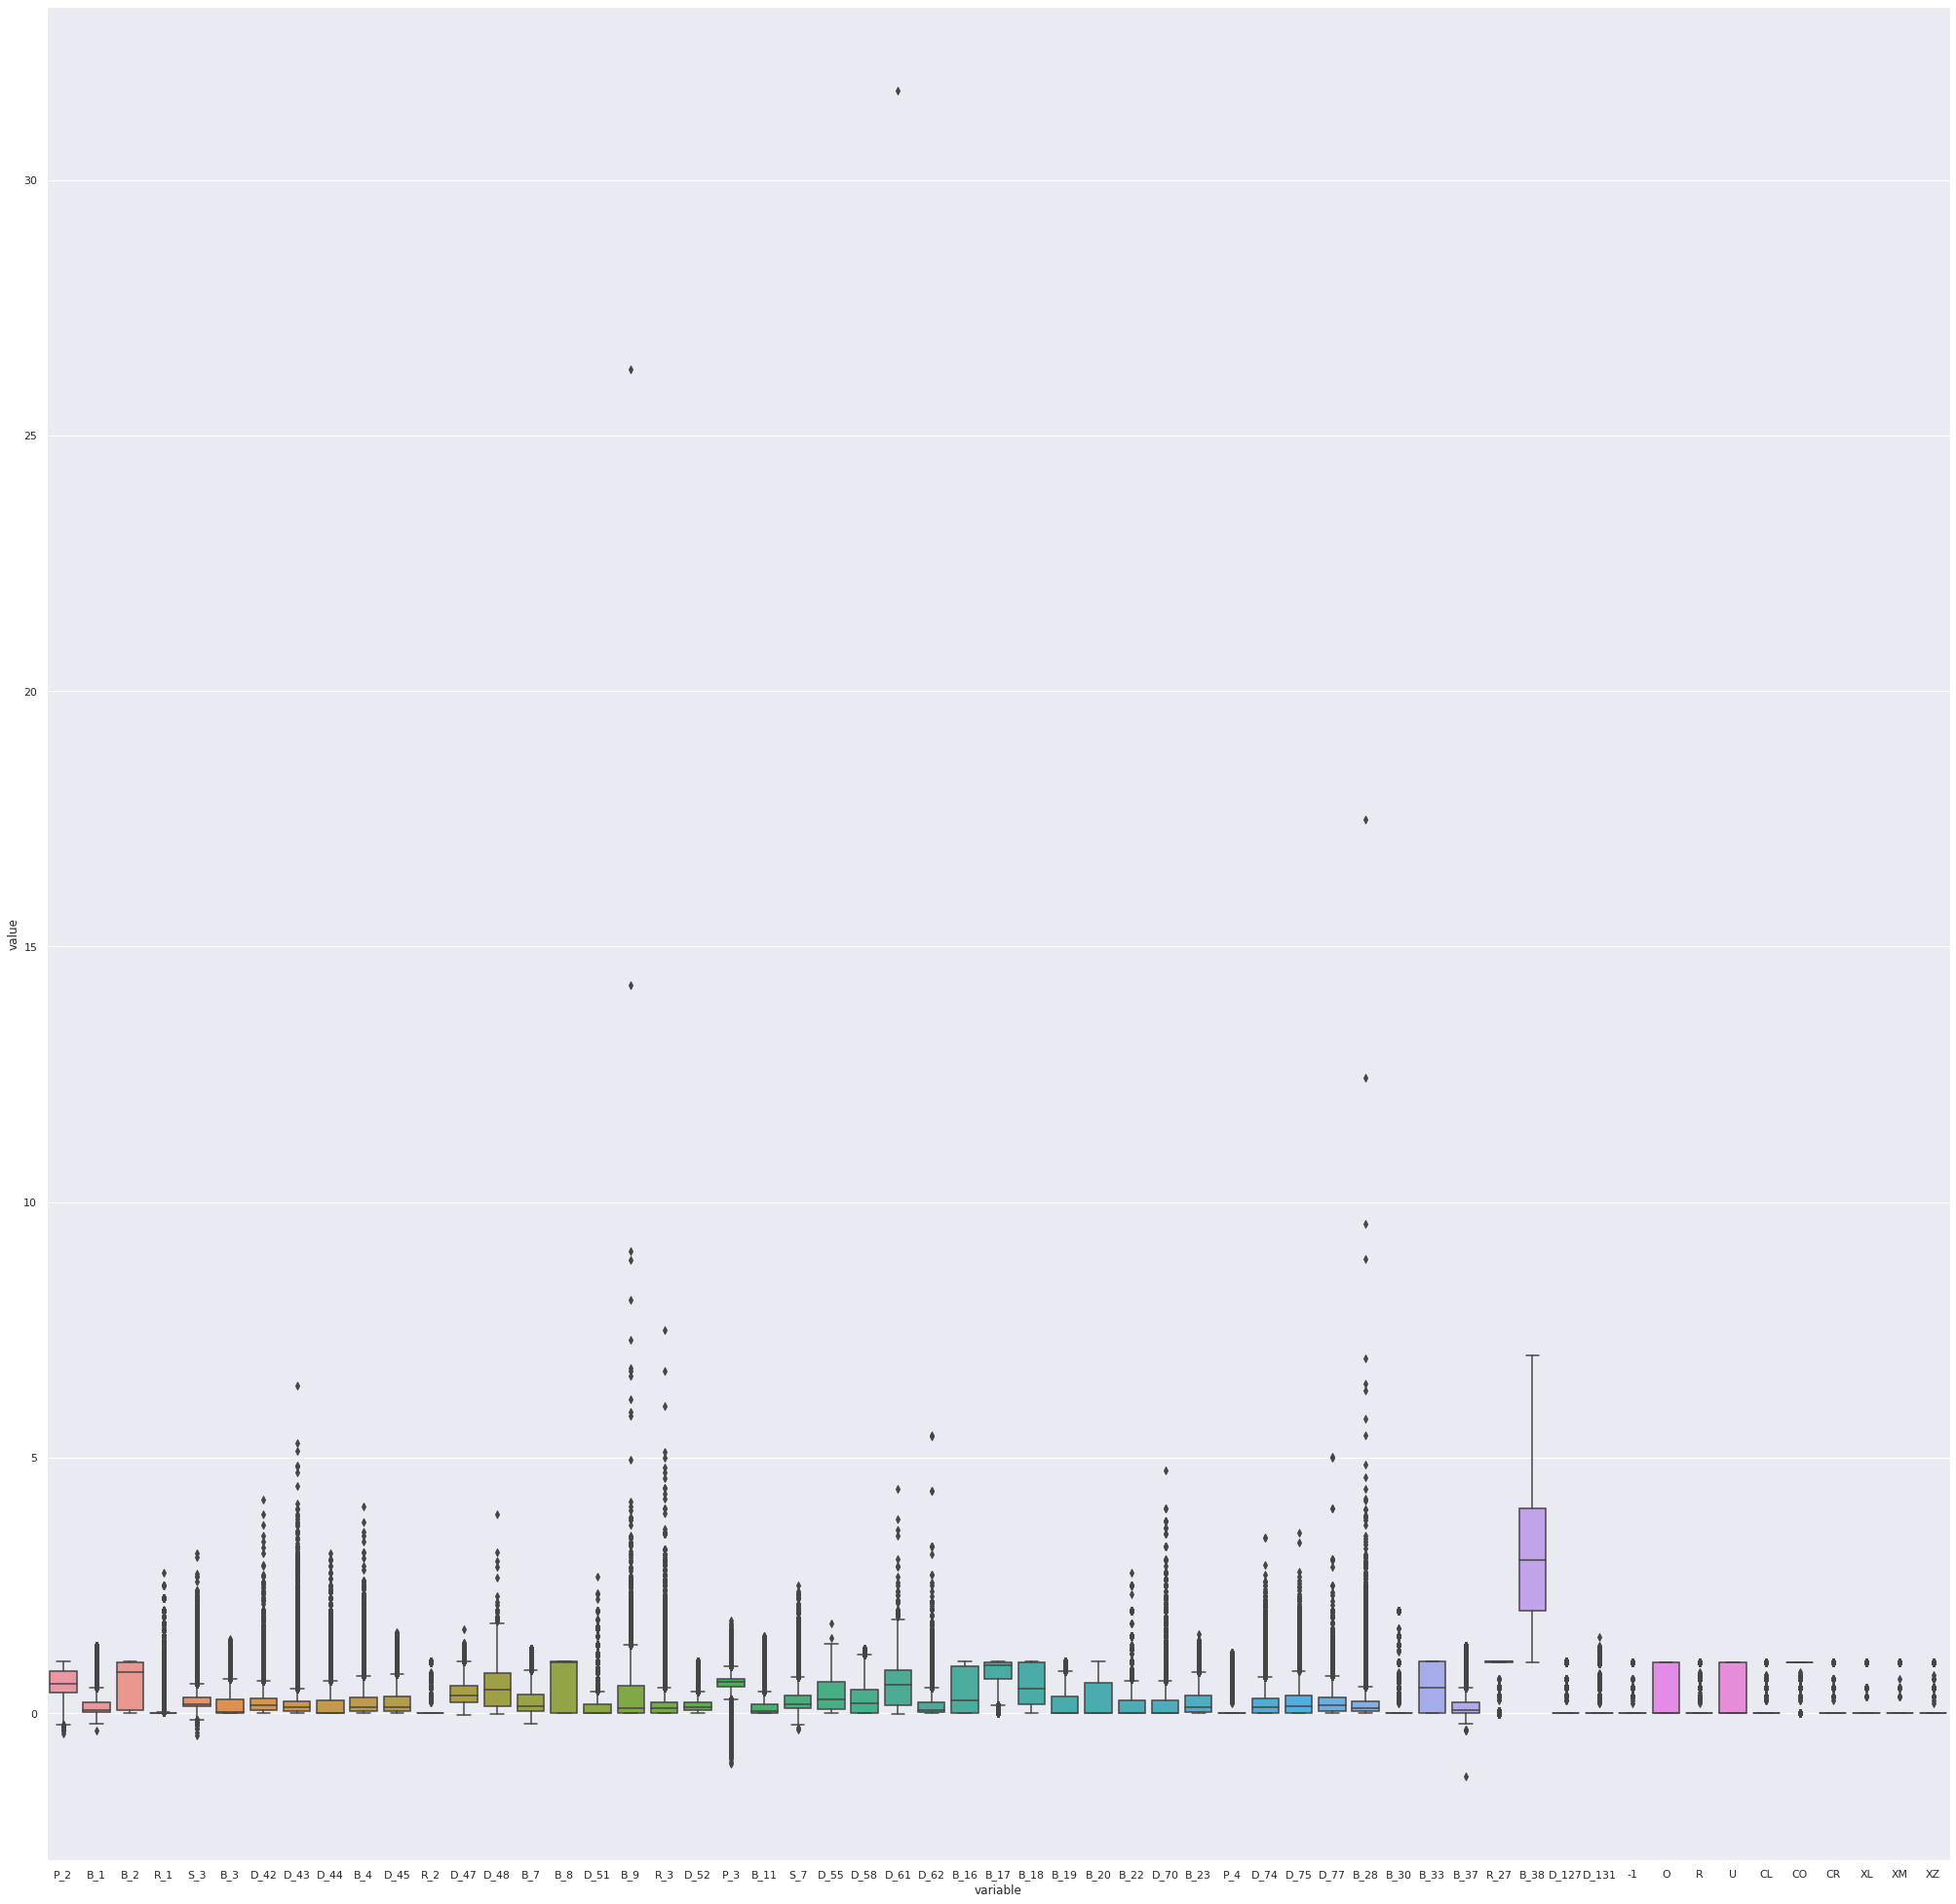

In [20]:
df_filtrado_2 = df_filtrado.drop("customer_ID", axis=1, inplace=False)
sns.set(rc = {'figure.figsize':(35,35)})
df = pd.DataFrame(data = df_filtrado_2, columns = df_filtrado_2.columns)
sns.boxplot(x="variable", y="value", data=pd.melt(df, "target"))

<AxesSubplot:xlabel='variable', ylabel='value'>

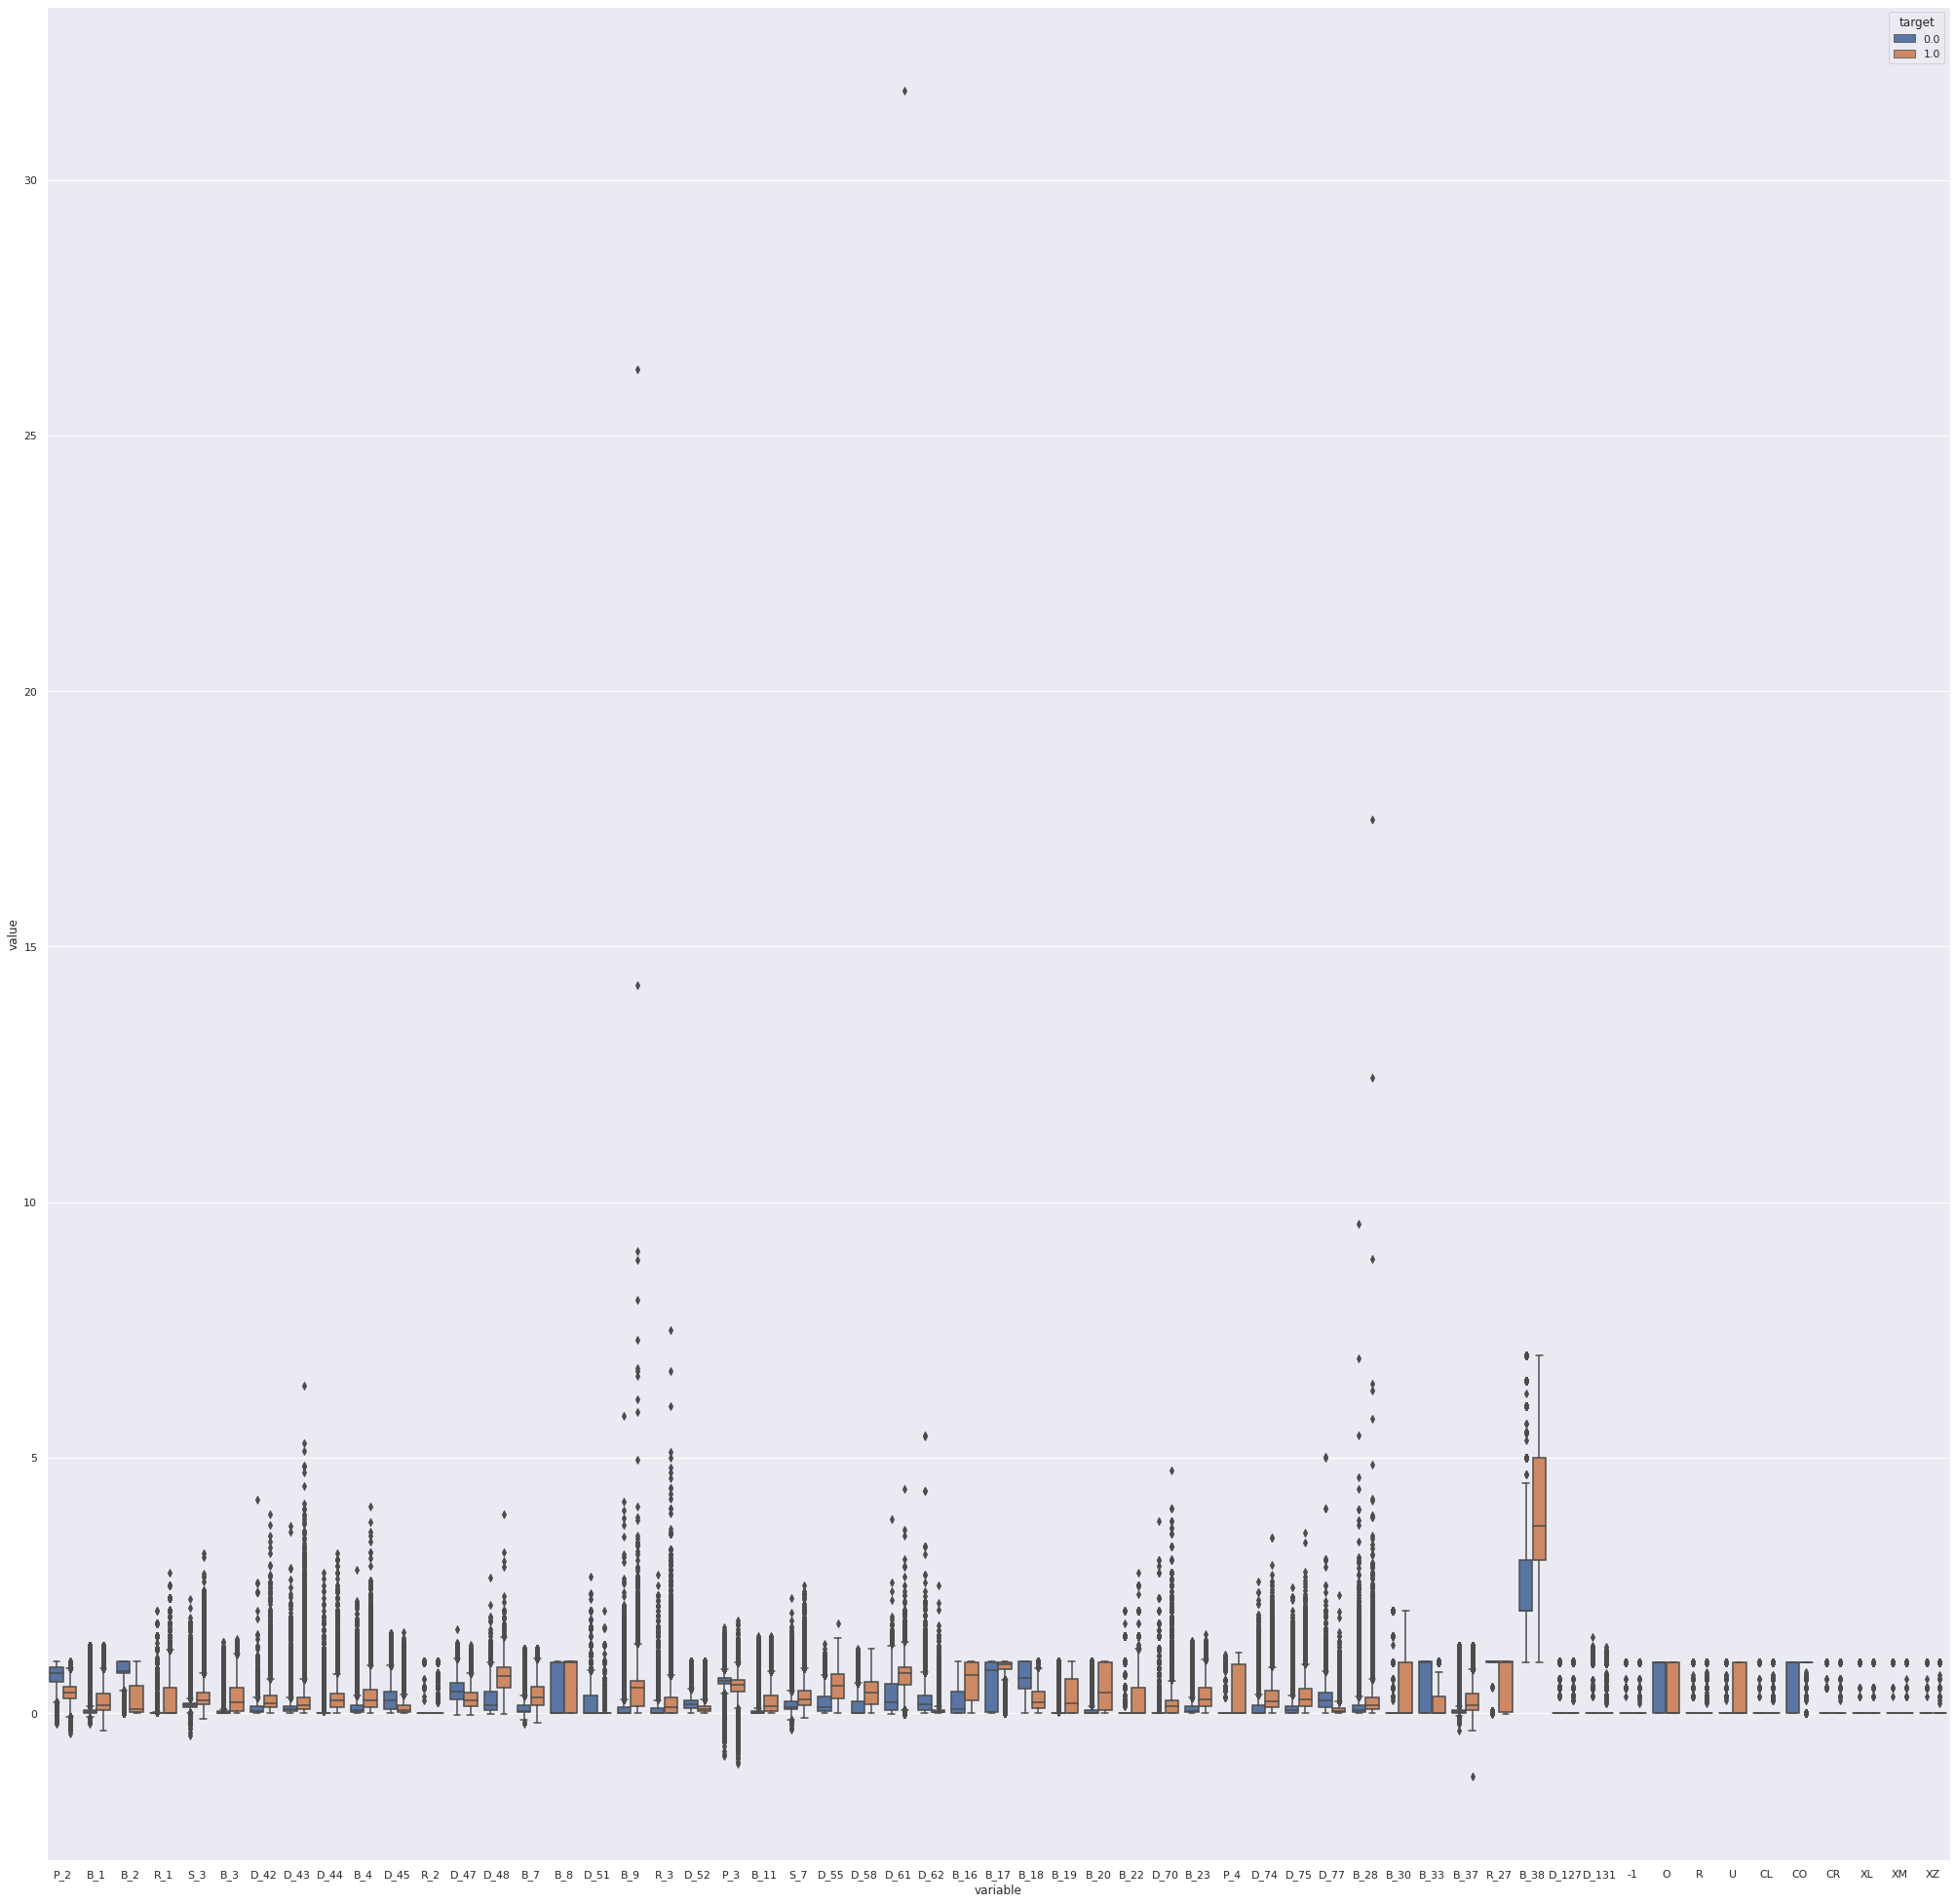

In [21]:
sns.boxplot(x="variable", y="value",hue = "target", data=pd.melt(df, "target"))

Luego de graficar los valores existentes en el conjunto de entrenamiento, podemos visualizar la aparición de outliers para la mayoría de las columnas del dataset. A simple vista nos resaltan mucho algunos registros que toman valores extremadamente altos y dificultan la legibilidad de los outlayers mas cercanos a la media.
Para poder realizar una mejor visualizacion, vamos a fijar un umbral inferior y superior al cual se transladaran los que lo superen.
- **Umbral inferior = -1**
- **Umbral superior = 8**

Una vez establecidos estos, volvemos a realizar los graficos:


<AxesSubplot:xlabel='variable', ylabel='value'>

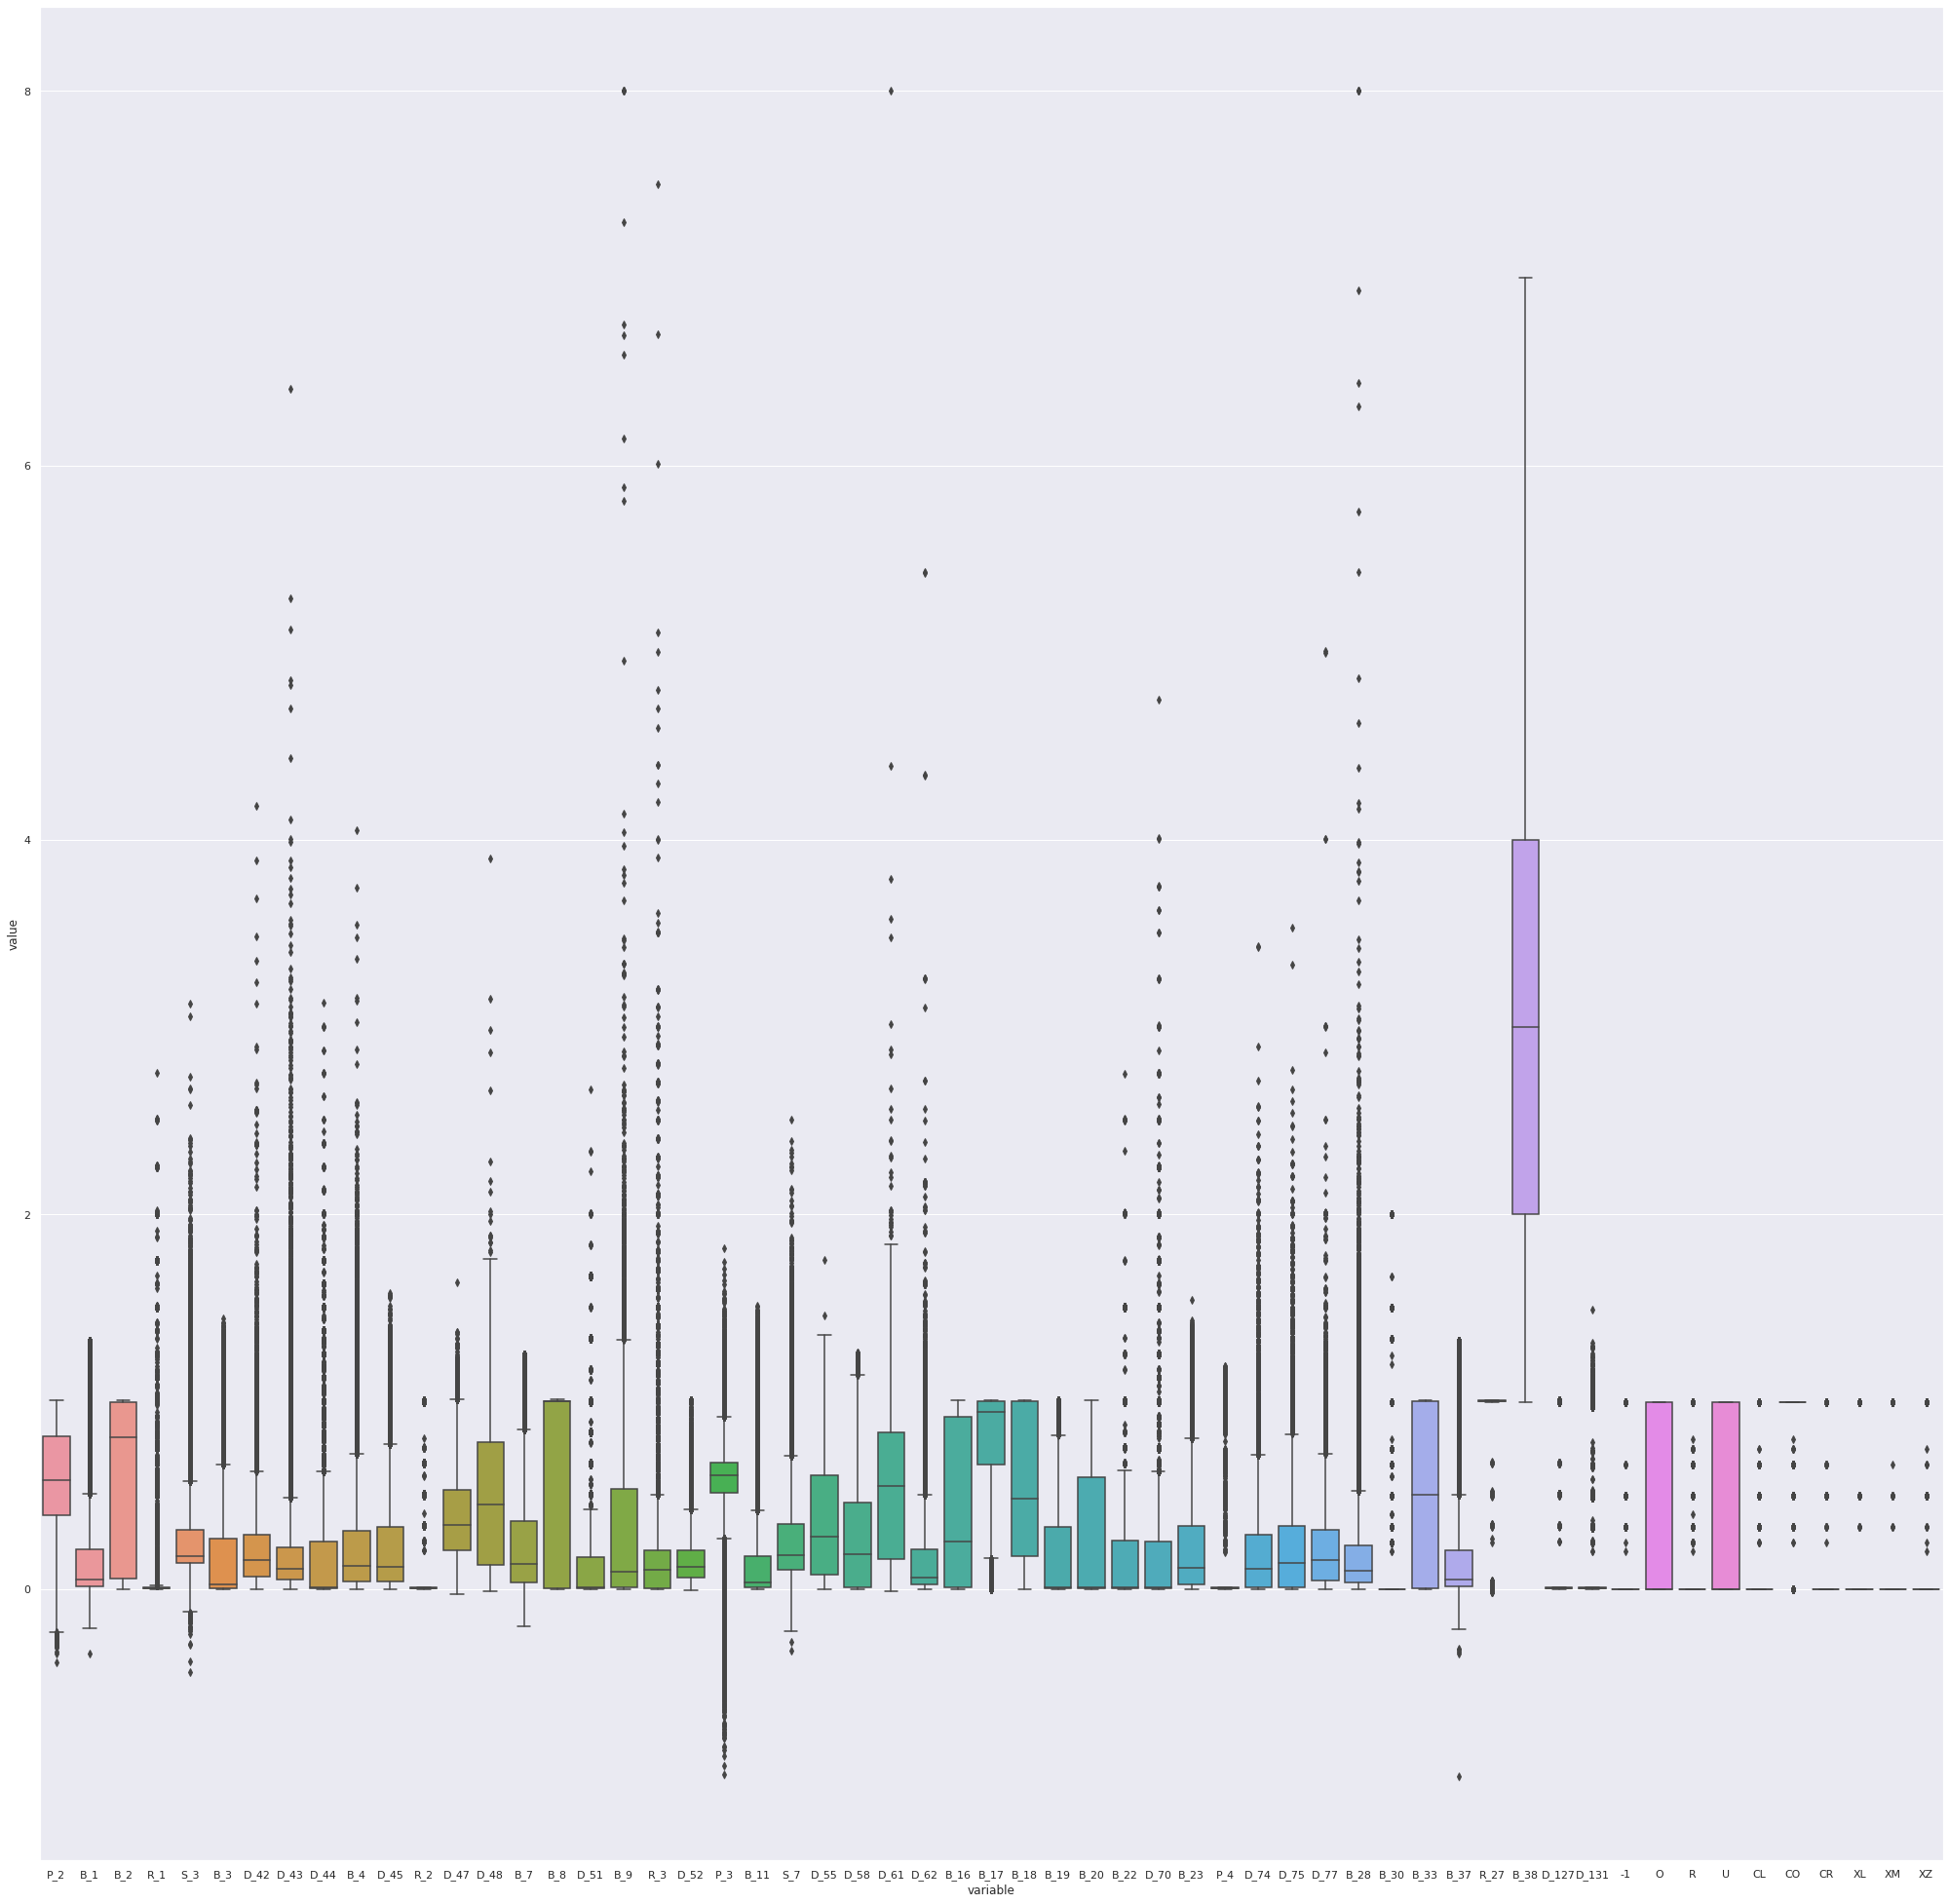

In [22]:
df.clip(-1, 8, inplace = True)
sns.boxplot(x="variable", y="value", data=pd.melt(df, "target"))

<AxesSubplot:xlabel='variable', ylabel='value'>

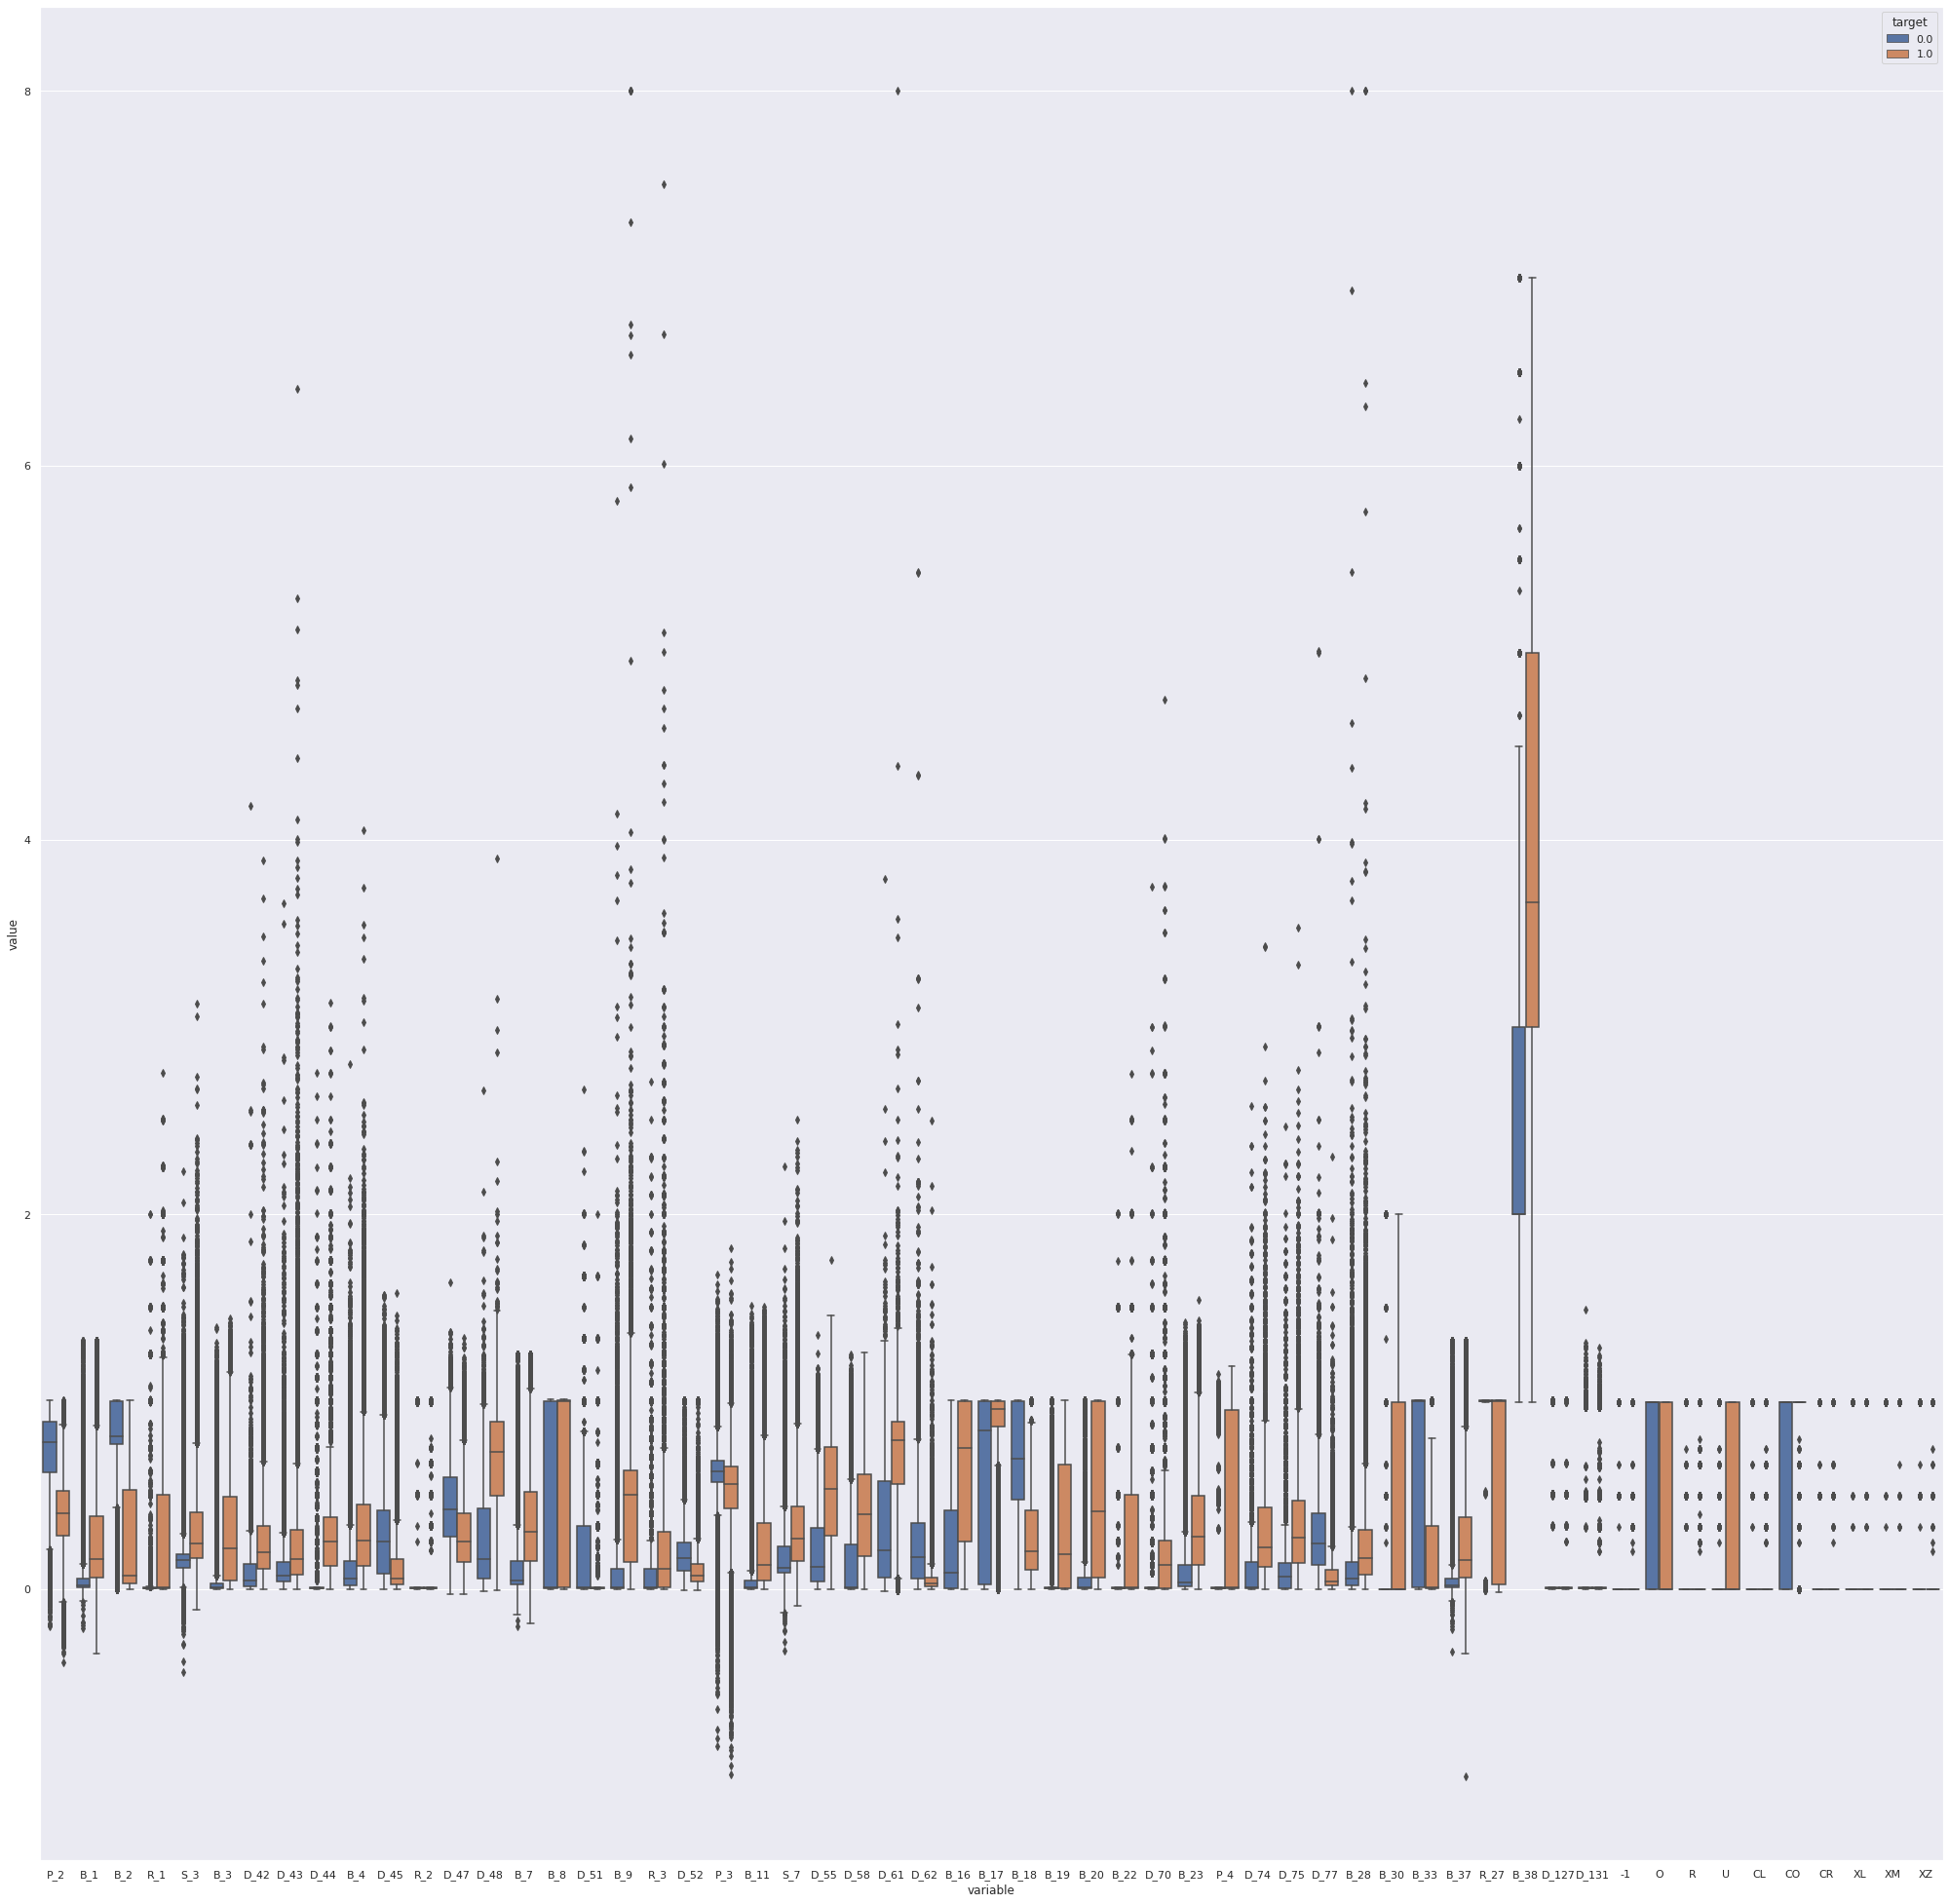

In [23]:
sns.boxplot(x="variable", y="value",hue = "target",data=pd.melt(df, "target"))

En estos ultimos boxplots, podemos ver como los registros que poseen **target = 1** (Representados en los plots naranjas) mayoritariamente ocupan la porcion de outliers que existen para los registros de **target = 0** (Representados en los plots azules). 

*Por ejemplo:* En los registros de las variables **B_37** se ve claramente como la porcion naranja ocupa casi la totalidad de los outliers de la porcion azul, comparando con el boxplot de esta misma variable que no esta dividido por targets, identificamos que casi toda esta porcion naranja esta ubicada entre sus outlayers.

Por esta razon, entendemos que estos valores atipicos son en su mayoria los registros con **target = 1** y la tarea que deberían realizar nuestros modelos son identificarlos, por lo que decidimos no modificarlos ni eliminarlos (Exceptuando los que posean valores mucho mas elevados en coparación que los demas que son reemplazados por el umbral correspondiente)

In [24]:
sns.set(rc = {'figure.figsize':(8,8)})
df_filtrado.drop("customer_ID", axis=1, inplace=True)
df_filtrado.clip(-1, 8, inplace = True)

## Datos Faltantes:

<AxesSubplot:>

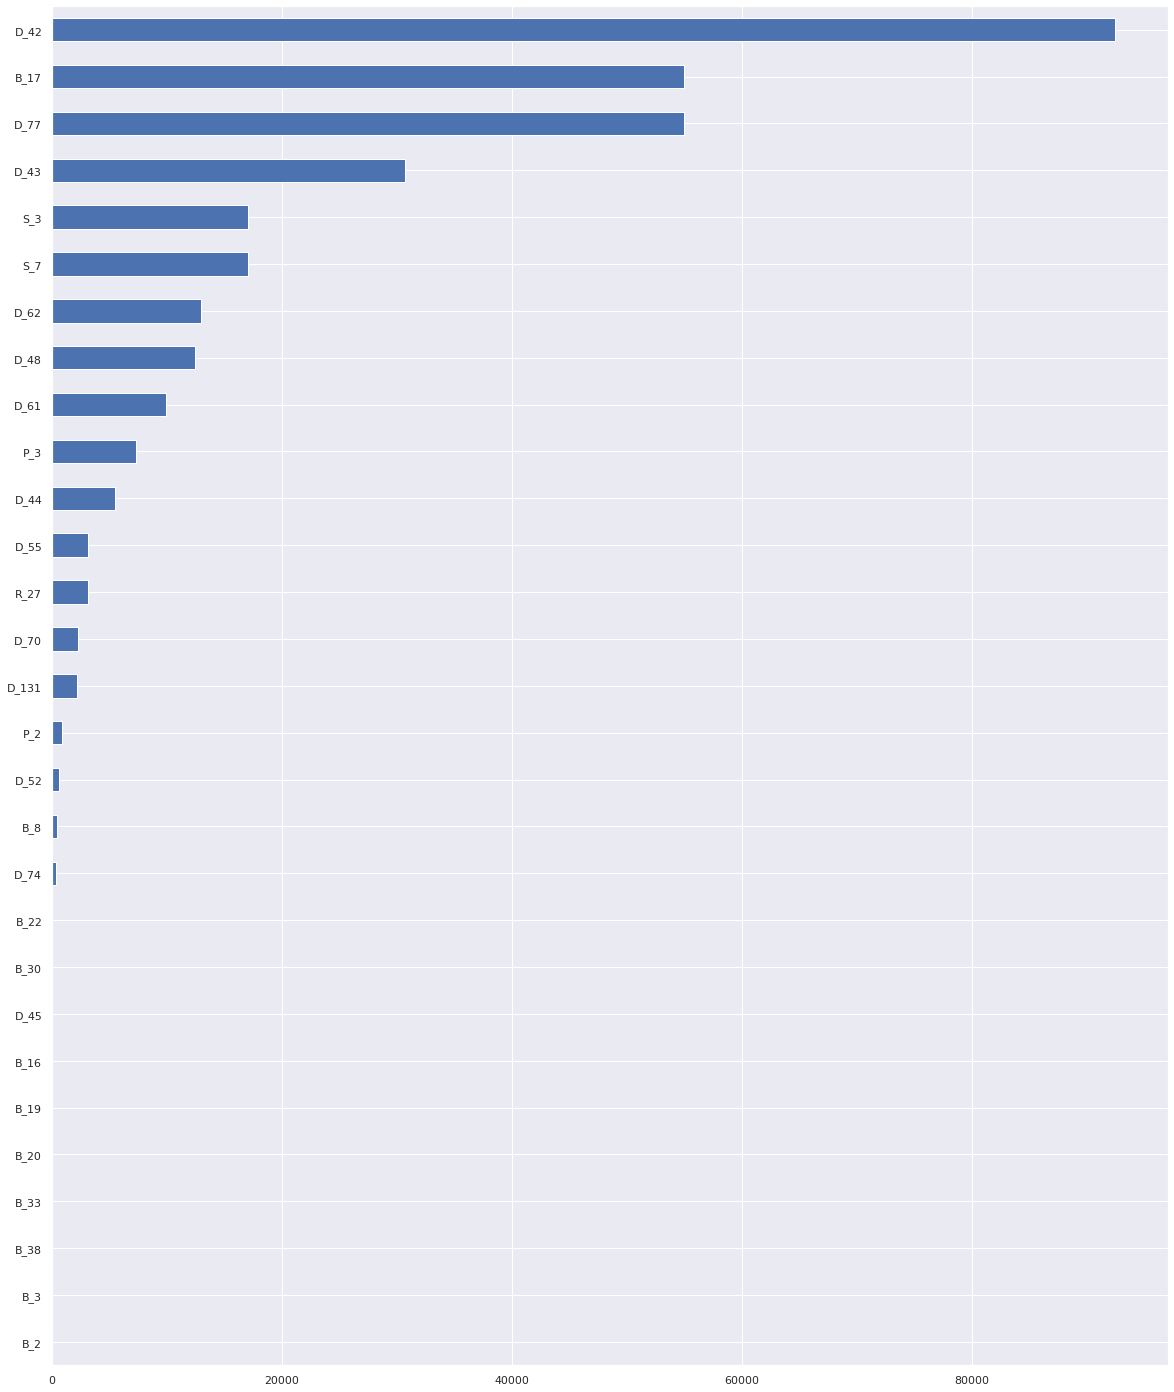

In [25]:
plt.rcParams['figure.figsize'] = (20,25)
df_filtrado.isna().sum().sort_values(ascending = True)[df_filtrado.isna().sum()>0].plot(kind='barh')

Dentro del dataframe que utilizaremos para entrenar, poseemos varias registros que poseen valores nulos en algunas de sus columnas.

Teniendo en cuenta el cálculo anterior del promedio en la reduccion de filas, podemos identificar que estos faltantes son el resultado de que para todas las entradas de un customer_ID, los valores pertenecientes a la columna eran nulos. Por esto, tomamos la decision de tomar que estos promedios son iguales a 0.

In [26]:
df_filtrado = df_filtrado.fillna(0)
df_filtrado.isna().sum()

P_2       0
B_1       0
B_2       0
R_1       0
S_3       0
B_3       0
D_42      0
D_43      0
D_44      0
B_4       0
D_45      0
R_2       0
D_47      0
D_48      0
B_7       0
B_8       0
D_51      0
B_9       0
R_3       0
D_52      0
P_3       0
B_11      0
S_7       0
D_55      0
D_58      0
D_61      0
D_62      0
B_16      0
B_17      0
B_18      0
B_19      0
B_20      0
B_22      0
D_70      0
B_23      0
P_4       0
D_74      0
D_75      0
D_77      0
B_28      0
B_30      0
B_33      0
B_37      0
R_27      0
B_38      0
D_127     0
D_131     0
target    0
-1        0
O         0
R         0
U         0
CL        0
CO        0
CR        0
XL        0
XM        0
XZ        0
dtype: int64

In [27]:
sns.set(rc = {'figure.figsize':(8,8)})

## Normalizacion y unificacion de valores en columnas:

## Descripcion de los datos:

Sabemos por la información brindada en la competencia (https://www.kaggle.com/competitions/amex-default-prediction/data) que el conjunto de datos originalmente contiene características de perfil agregadas para cada cliente en cada fecha de estado de cuenta. Los atributos vienen anonimizados (probablemente por una cuestión de sensibilidad de datos, véase las normas sobre este tema en Argentina: http://servicios.infoleg.gob.ar/infolegInternet/anexos/60000-64999/64790/norma.htm) como también normalizados. A la vez sabemos que se clasifican en las siguientes categorías generales:

D* = Variables de morosidad

S* = Variables de gasto

P* = Variables de pago

B* = Variables de balance

R_* = Variables de riesgo

Y que los siguientes atributos son categóricos:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

A partir de la limpieza basada en la correlación de los features y el target descrita anteriormente, se pudo reducir notoriamente la cantidad de columnas del dataset.  Cabe decir que las variables pertenecientes a los grupos (D) y (B) fueron aquellas que en general demostraron tener mayor correlatividad al target.

Adicionalmente, al ser posible la existencia de múltiples registros por cada cliente, agrupamos las filas correspondientes a el mismo cliente según el promedio de sus atributos numéricos. También se generaron nuevas columnas "dummies" para los casos de las columnas categóricas aún existentes en nuestro conjunto. 

# Modelos:

Para la elección de un modelo certero a la hora de predecir el target de los clientes, haremos uso de las métricas precisión (precision/accuracy), exhaustividad (recall) y f1-score. Estas métricas se calculan de la siguiente manera:

Precisión: $\frac{TP}{TP + FP}$

Exhaustividad: $\frac{TP}{TP + FN}$

F1 Score: $\frac{2*Precisión*Exhaustividad}{Precisión + Exhaustividad}$

donde TP = True Positive; FP = False Positive; FN = False Negative.

Un True Positive es una predicción que se predijo como positiva y el resultado real fue positivo; un False Positive, cuando se predijo positivamente y resultó estar errada la predicción. Un True Negative, análogamente, es un cuando se predice negativamente y este resulta serlo; un False Negative, cuando resultó ser positivo con una predicción de resultado desfavorable.

Debido a que la métrica f1-score involucra las otras dos métricas mencionadas de una manera equilibrada, es decir, su valor depende de un balance de ellas, esta es la que utilizaremos como principal indicador cuando queramos comparar distintos modelos de predictores.



In [28]:
def heatmap(modelo):
    y_pred = modelo.predict(x_test)
    ds_resultados = pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])
    tabla = confusion_matrix(ds_resultados['test'], ds_resultados['pred'])
    sns.heatmap(tabla,annot=True, fmt='g')
    return ds_resultados

def metricas(df):
    print("Accuracy: " + str(accuracy_score(df['test'], df['pred'], normalize=True)))
    print("Recall: " + str(recall_score(df['test'], df['pred'])))
    print("F1: " + str(f1_score(df['test'], df['pred'])))

## Tipado y reducción de memoria de los atributos:

In [29]:
le = LabelEncoder()

df_filtrado.target = df_filtrado.target.astype('int8')

for columna in df_filtrado.columns:
    if df_filtrado[columna].dtype == object:
        df_filtrado[columna] = le.fit_transform(df_filtrado[columna].astype(str))
    elif df_filtrado[columna].dtype == 'float64':
        df_filtrado[columna] = df_filtrado[columna].astype('float32')
    else:
        pass


## Split de los datos para testing:

In [30]:
df_train_data_x = df_filtrado.drop(columns = ['target'], axis='columns', inplace=False)
df_train_data_y = df_filtrado['target'].copy()
x_train, x_test, y_train, y_test = train_test_split(df_train_data_x, df_train_data_y, test_size=0.2, random_state=12, stratify=df_filtrado['target'].values)

## Random Forest:

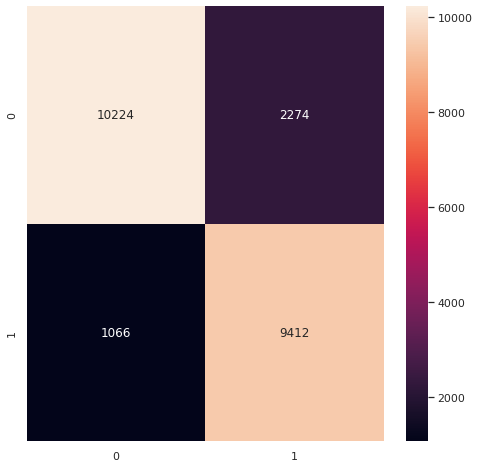

In [31]:
n_estimators = 10
random_state = 10

param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}

arbol = RandomForestClassifier(random_state=random_state,
                               class_weight = "balanced",
                               n_estimators = n_estimators,
                               max_depth = 10)
rf_random = GridSearchCV(estimator = arbol, param_grid = param_grid, cv = 3, verbose=0, n_jobs = -1)
rf_random.fit(x_train,y_train)

random_forest_modelo = rf_random.best_estimator_
ds_resultados_rf = heatmap(random_forest_modelo)

In [32]:
metricas(ds_resultados_rf)

Accuracy: 0.8546309192200557
Recall: 0.8982630272952854
F1: 0.8493051795704746


## XGBoost:

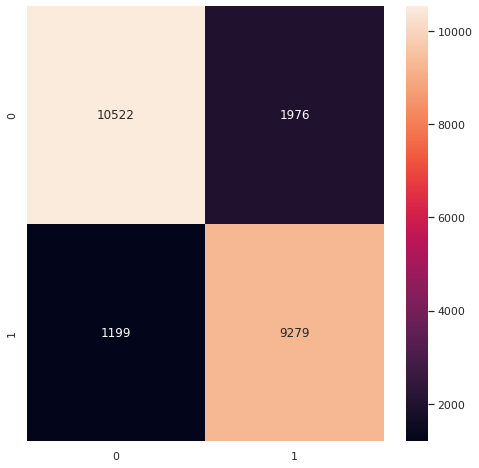

In [33]:
xgb_modelo = xgb.XGBClassifier(
    random_state=random_state, 
    n_estimators=n_estimators**2, 
    objective="binary:logistic")

xgb_modelo.fit(x_train, y_train, sample_weight=compute_sample_weight("balanced", y_train))

ds_resultados_xgb = heatmap(xgb_modelo)
y_pred_testing = xgb_modelo.predict_proba(x_test)

In [34]:
metricas(ds_resultados_xgb)

Accuracy: 0.8618123259052924
Recall: 0.8855697652223706
F1: 0.8539088022822435


In [35]:
xgb_modelo_maxdepth = xgb.XGBClassifier(
    random_state=random_state, 
    n_estimators=n_estimators, 
    objective="binary:logistic",
    max_depth = 10)
xgb_modelo_maxdepth.fit(x_train, y_train, sample_weight=compute_sample_weight("balanced", y_train))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=10,
              reg_alpha=0, reg_lambda=1, ...)

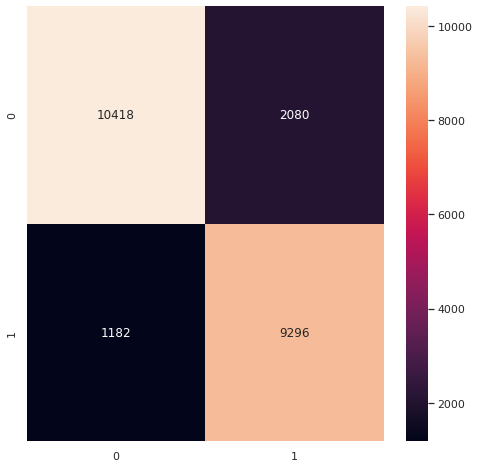

In [36]:
ds_resultados_xgb = heatmap(xgb_modelo_maxdepth)

In [37]:
metricas(ds_resultados_xgb)

Accuracy: 0.8580257660167131
Recall: 0.887192212254247
F1: 0.8507367072389495


Como podemos observar, el primer modelo resultó tener mejores métricas, así que nos quedamos con ese.

In [38]:
del xgb_modelo_maxdepth

## SVM:

In [39]:
stand_scaler = StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm = stand_scaler.fit_transform(x_test)

In [40]:
param_grid = { 
    'C': [6,7,8],
}
clf = LinearSVC(class_weight='balanced', dual=False, penalty = "l1", random_state = random_state)
svc_random = GridSearchCV(estimator = clf, param_grid = param_grid, cv=2, verbose=0, n_jobs = -1)
svc_random.fit(x_train_norm,y_train)
svc_modelo = svc_random.best_estimator_

Text(48.5, 0.5, 'True')

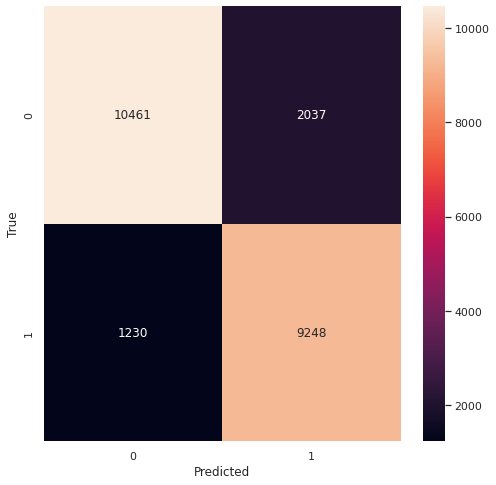

In [41]:
y_pred_norm = svc_modelo.predict(x_test_norm)
cm = confusion_matrix(y_test,y_pred_norm)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [42]:
ds_resultados_svm = pd.DataFrame(zip(y_test,y_pred_norm),columns=['test','pred'])
metricas(ds_resultados_svm)

Accuracy: 0.857808147632312
Recall: 0.8826111853407139
F1: 0.8498828286541379


## Ensamble Voting:

In [43]:
ensamble_voting_modelo = VotingClassifier(estimators = [('rf', random_forest_modelo), ('xgb', xgb_modelo), ('svm', svc_modelo)], voting = 'hard')
ensamble_voting_modelo.fit(x_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     criterion='entropy',
                                                     max_depth=10,
                                                     n_estimators=10,
                                                     random_state=10)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=...
                                            learning_rate=0.30000

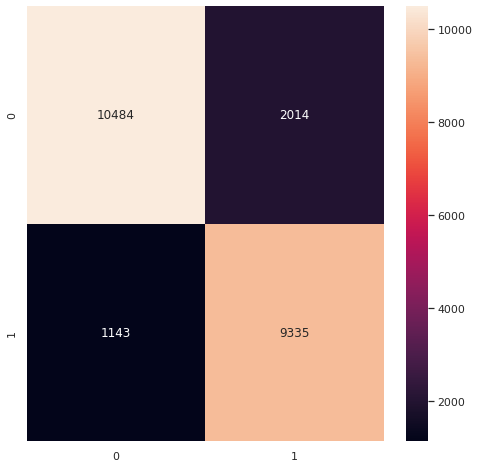

In [44]:
ds_resultados_ensamble_voting = heatmap(ensamble_voting_modelo)

In [45]:
metricas(ds_resultados_ensamble_voting)

Accuracy: 0.8625957520891365
Recall: 0.8909142966214927
F1: 0.8553626242726898


## Red Neuronal

Para poder reproducir los resultados de nuestra red neuronal en todas las ejecuciones, primero tenemos que setear una seed, para esta, utilizamos la misma seed que usamos para el sampleo de los datos:

In [46]:
## Reproducibilidad del seteo: ##
## https://deeplizard.com/learn/video/HcW0DeWRggs ##
import os
import random as rn
import tensorflow as tf
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(SEED_GRUPO)
rn.seed(SEED_GRUPO)
tf.random.set_seed(SEED_GRUPO)

Una vez hecho esto, podemos pasar a la creacion de nuestra red:

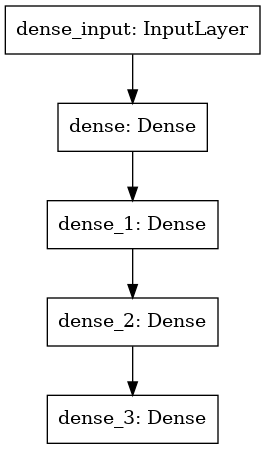

In [47]:
n_columnas = len(x_test.columns)
classes=int(df_filtrado.loc[:,'target'].max()+1)

red_modelo = Sequential([
    # input_shape solo en la primer capa
    Dense(n_columnas, input_shape = (n_columnas,), activation='relu'),
    Dense(n_columnas, activation='relu'),
    Dense(n_columnas*2, activation='relu'),
    Dense(1, activation='sigmoid')
    ])

plot_model(red_modelo)

In [48]:
red_modelo.compile(loss='binary_crossentropy', optimizer="Adam", metrics=['binary_accuracy'])
history = red_modelo.fit(x_train,y_train,epochs= 32, batch_size= 256,verbose=0)

2022-08-02 04:53:28.074980: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [49]:
y_pred = red_modelo.predict(x_test)
a = pd.DataFrame(data = y_pred)
b = a[0].values
c = []
for valor in b:
    if valor > 0.5:
        c.append(1)
    else:
        c.append(0)
d = pd.DataFrame(data = c)

Text(48.5, 0.5, 'True')

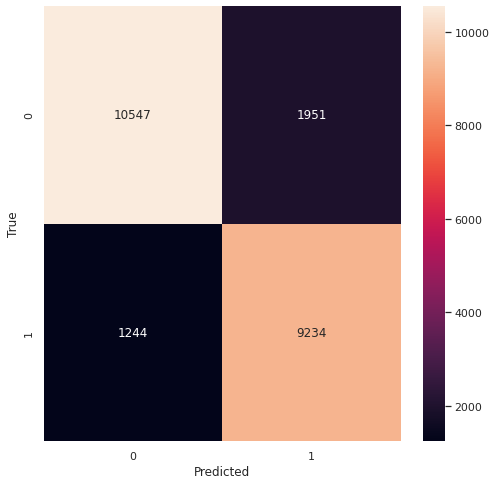

In [50]:
tabla = confusion_matrix(y_test, d)
sns.heatmap(tabla,annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [51]:
print("  Accuracy : %.5f" % accuracy_score(y_test, d))
print("     Recall: %.5f" % recall_score(y_test, d))
print("  f-measure: %.5f" % f1_score(y_test, d))

  Accuracy : 0.86094
     Recall: 0.88128
  f-measure: 0.85251


## Ensamble Cascading:

Ya que no existe libería que nos permita realizar este ensamble, tenemos que generar nuestras propias funciones:

In [52]:
class Cascading:
    def __init__(self, dict_modelos, umbral):
        self.cantidad_modelos = len(dict_modelos)
        self.modelo_final = list(dict_modelos)[-1]
        self.modelos = dict_modelos
        self.umbral = umbral

        
    def predict(self, x_test, y_test, total = False):
        # Genero variable salida y remanentes del predict.
        out = pd.DataFrame(columns = ["target", "predict"])
        remanentes_x = x_test.copy()
        remanentes_y = y_test.copy()
        
        # Itero todos los modelos.
        for modelo in self.modelos:
            if modelo == self.modelo_final and total == True:
                # Si llega al ultimo modelo del ensamble, obtiene clasificaciones exactas para los remanentes.
                modelo_pred = self.modelos[modelo]["fun_clas"](self.modelos[modelo]["modelo"], remanentes_x)
                prediccion = pd.DataFrame(data = remanentes_y)
                prediccion["predict"] = modelo_pred
                # Se añaden estas a el dataset de predecidas.
                out = pd.concat([out, prediccion], axis = 0)
                return out, None
            else:
                # Se obtienen los % de pertenencia a clase 1.
                modelo_pred = self.modelos[modelo]["fun_prob"](self.modelos[modelo]["modelo"], remanentes_x)
                prediccion = pd.DataFrame(data = remanentes_y)
                prediccion["predict"] = modelo_pred
                # Los que superan el umbral, quedan definidos como 1
                definidas = prediccion[prediccion["predict"] > self.umbral]
                #definidas["predict"] = 1
                definidas.loc[:, "predict"] = 1
                # Se añaden estas a el dataset de predecidas y se dropean de la tabla de filas a probar
                out = pd.concat([out, definidas], axis = 0)
                remanentes_x.drop(definidas.index, inplace = True)
                remanentes_y.drop(definidas.index, inplace = True)
                
        out["target"] = out["target"].astype(int)
        out["predict"] = out["predict"].astype(int)
        return out, remanentes_x

## Documentacion de Cascading():

* Cascading(dict_modelos: dict, umbral: float): Esta clase genera un ensable Cascading.
   - dict_modelos: Diccionario de diccionarios que contiene los modelos que se van a utilizar (con orden sensible), este diccionario debe tener la siguiente estructura:  
  {
    "Nombre": {
        "modelo" : #Modelo entrenado#,
        "fun_prob" : #Funcion de probabilidades#,
        "fun_clas" : #Funcion de clasificacion#
    }
  }

  @param Funcion de probabilidades: Funcion que recibe (modelo, x_test) y devuelve un np.array con las probabilides de pertenencia a clase 1.

  @param Funcion de clasificacion: Funcion que recibe (modelo, x_test) y devuelve un np.array con una clasificacion (clase 0 / clase 1).

  - umbral: valor mínimo de probabilidad con el que el ensamble puede asegurar que, según este, puede estar clasificado correctamente como tipo 1


* Cascading.predict(self: Cascading, x_test: DataFrame, y_test: DataFrame, total: bool) -> tuple:

  @param x_test: Datos a ser evaluados por los modelos.
  
  @param y_test: Datos desde los cuales se verifica el si el modelo predijo bien.
  
  @param total: por default True, clasifica con no_class si está en True; si es False, clasifica todo.
  
  @return (out, no_class): out es el DataFrame de los datos clasificados; no_class es el DataFrame de los datos que no pudo clasificar. Si total está en True, no_class es None.

Una vez creado nuestro modelo de cascading, procedemos a realizar las predicciones con los siguientes ensambles creados previamente:

1. Red Neuronal.
2. Random Forest.
3. XGBoost.

In [53]:
def fun_prob_red(modelo, x_test):
    return modelo.predict(x_test)

def fun_clas_rf_xgb(modelo, x_test):
    out = []
    predicciones = modelo.predict(x_test)
    for prediccion in predicciones:
        out.append([prediccion])
    return np.array(out)

def fun_prob_rf_xgb(modelo, x_test):
    probabilidades = modelo.predict_proba(x_test)
    probabilidades = np.delete(probabilidades,0,axis = 1)
    return probabilidades

dict_modelos = {
    "Red":{
        "modelo":red_modelo,
        "fun_prob":fun_prob_red,
        "fun_clas":None
    },
    "Random_Forest":{
        "modelo":random_forest_modelo,
        "fun_prob":fun_prob_rf_xgb,
        "fun_clas":fun_clas_rf_xgb
    },
    "XGBoost":{
        "modelo":xgb_modelo,
        "fun_prob":fun_prob_rf_xgb,
        "fun_clas":fun_clas_rf_xgb
    }
}

In [54]:
modelo_cascading_1 = Cascading(dict_modelos, 0.99)
resultados_cascading = modelo_cascading_1.predict(x_test, y_test, total = False)

In [55]:
out, no_clas = resultados_cascading

In [56]:
no_clas

,P_2,B_1,B_2,R_1,S_3,B_3,D_42,D_43,D_44,B_4,...,-1,O,R,U,CL,CO,CR,XL,XM,XZ
50699,0.466075,0.148131,0.092552,0.501359,0.123382,0.447703,0.000000,0.000000,0.252772,0.320829,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
63573,0.461154,0.029179,0.059622,0.004583,0.173706,0.062602,0.000000,0.051569,0.005333,0.174487,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
109847,0.844817,0.172716,0.022588,0.004321,0.255108,0.483036,0.000000,0.032942,0.002843,0.019655,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
81647,0.390839,0.003484,0.812953,0.004521,0.000000,0.006730,0.000000,0.000000,0.131354,0.245824,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
32255,0.531923,0.519495,0.044563,0.259270,0.136752,0.805830,0.000000,0.118133,0.130996,1.237683,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59996,0.616328,0.295959,0.076041,0.009304,0.497519,0.213557,0.000000,0.022040,0.134298,0.594601,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1200,0.847561,0.016400,1.005889,0.008405,0.142458,0.001256,0.000000,0.001145,0.008097,0.090299,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
71135,0.588566,0.104117,0.333214,0.000480,0.218904,0.093946,0.000000,0.207293,0.259302,0.540232,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
92320,0.316989,0.434279,0.035093,0.255271,0.195429,0.384429,0.290498,0.290798,0.085860,0.147821,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [57]:
out.sort_values(by = "predict", ascending = True)

,target,predict
11448,1,1
46841,1,1
87405,1,1
50892,1,1
18986,1,1
...,...,...
22415,1,1
65035,1,1
47231,1,1
101433,0,1


Text(48.5, 0.5, 'True')

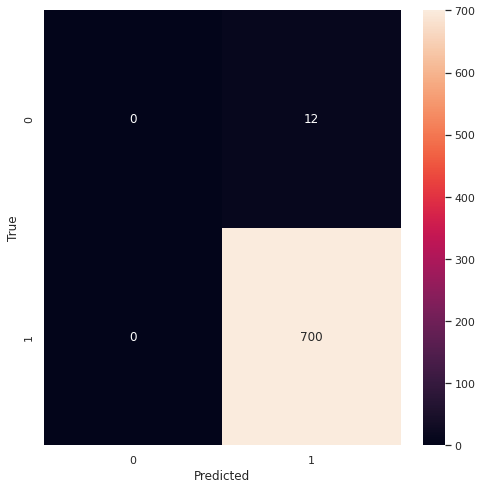

In [58]:
tabla = confusion_matrix(out['target'], out['predict'])
sns.heatmap(tabla,annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [59]:
print("Accuracy: " + str(accuracy_score(out['target'], out['predict'], normalize=True)))
print("Recall: " + str(recall_score(out['target'], out['predict'])))
print("F1: " + str(f1_score(out['target'], out['predict'])))

Accuracy: 0.9831460674157303
Recall: 1.0
F1: 0.9915014164305949


In [60]:
modelo_cascading_2 = Cascading(dict_modelos, 0.95)
resultados_cascading2 = modelo_cascading_2.predict(x_test, y_test, total = False)

In [61]:
out2, no_clas2 = resultados_cascading2

In [62]:
no_clas2

,P_2,B_1,B_2,R_1,S_3,B_3,D_42,D_43,D_44,B_4,...,-1,O,R,U,CL,CO,CR,XL,XM,XZ
50699,0.466075,0.148131,0.092552,0.501359,0.123382,0.447703,0.0,0.000000,0.252772,0.320829,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
63573,0.461154,0.029179,0.059622,0.004583,0.173706,0.062602,0.0,0.051569,0.005333,0.174487,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
109847,0.844817,0.172716,0.022588,0.004321,0.255108,0.483036,0.0,0.032942,0.002843,0.019655,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
81647,0.390839,0.003484,0.812953,0.004521,0.000000,0.006730,0.0,0.000000,0.131354,0.245824,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
32255,0.531923,0.519495,0.044563,0.259270,0.136752,0.805830,0.0,0.118133,0.130996,1.237683,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2418,0.868224,0.015248,0.816805,0.000561,0.434756,0.018087,0.0,0.064153,0.009765,0.043205,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
59996,0.616328,0.295959,0.076041,0.009304,0.497519,0.213557,0.0,0.022040,0.134298,0.594601,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1200,0.847561,0.016400,1.005889,0.008405,0.142458,0.001256,0.0,0.001145,0.008097,0.090299,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
71135,0.588566,0.104117,0.333214,0.000480,0.218904,0.093946,0.0,0.207293,0.259302,0.540232,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [63]:
out2

,target,predict
98383,1,1
38419,0,1
91766,1,1
110845,1,1
29521,1,1
...,...,...
101437,1,1
33902,0,1
87302,1,1
112594,1,1


Text(48.5, 0.5, 'True')

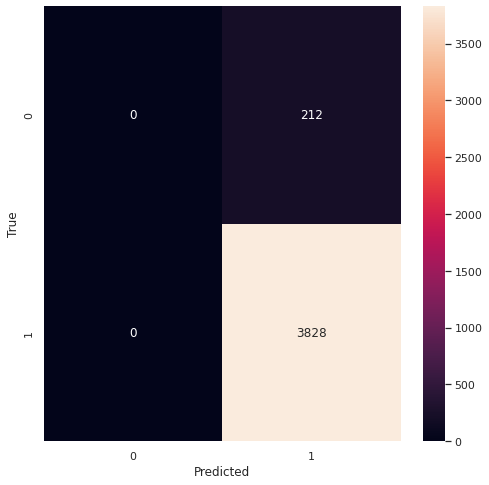

In [64]:
tabla = confusion_matrix(out2['target'], out2['predict'])
sns.heatmap(tabla,annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [65]:
print("Accuracy: " + str(accuracy_score(out['target'], out['predict'], normalize=True)))
print("Recall: " + str(recall_score(out['target'], out['predict'])))
print("F1: " + str(f1_score(out['target'], out['predict'])))

Accuracy: 0.9831460674157303
Recall: 1.0
F1: 0.9915014164305949


# Conclusiones:

Observando los resultados obtenidos a partir de los distintos modelos, se puede decir que, si bien no se puede predecir con total certeza si un cliente dejará de pagar, sí se puede hacer con una alta probabilidad.

A partir del dataframe filtrado resultante, se puede observar que las variables de Delincuencia y Balance son las más correlacionadas al target. Es por ello que podemos afirmar que, en estos modelos, mientras menos faltantes de estos tipos de datos haya, mejor podrá ser la predicción resultante.

En línea con lo expuesto anteriormente, al estar anonimizados los datos, no se sabe cuáles son los aportados. Creemos que, de no estarlo, variables como la categoría del clientes, su antigüedad o la deuda podrían ser de utilidad si se tuvieran de manera explícita.

Si el sistema entrase en producción, si existiera intervención humana, entonces podría causar outliers, inconsistencias en los datos, o valores nulos que harían que los modelos tengan una probabilidad de acierto más baja; asimismo, si se tuviera que mantener a largo plazo, habría que asegurarse de borrarle los datos viejos y añadirle los datos nuevos, de esta manera se evitaría el overfitting.